### XGBoost-based prediction of residual properties of aged FRP composites
Copyright (C) 2025 João Paulo D. de S. Pereira
License: GPL-3.0 (https://www.gnu.org/licenses/gpl-3.0.en.html)

In [78]:
# Library imports and global settings
from category_encoders.target_encoder import TargetEncoder
from contextlib import suppress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({
    'font.size': 20,            # Global font size
    'axes.titlesize': 20,       # Axes title size
    'axes.labelsize': 20,       # Axis label size
    'xtick.labelsize': 20,      # X-axis tick label size
    'ytick.labelsize': 20,      # Y-axis tick label size
    'legend.fontsize': 20,      # Legend font size
    'figure.titlesize': 20,     # Figure title
    'axes.titlepad': 20,        # Title offset from graph
    'axes.labelpad': 15         # Label offset from graph
})
import numpy as np
from scipy.optimize import curve_fit
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display
from sklearn.metrics import r2_score, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import PartialDependenceDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback, DeltaYStopper
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
import time
from datetime import datetime
import seaborn as sns
from pprint import pprint

In [79]:
# Record and display execution start time
start_time = time.time()
now = datetime.now()
print(now.strftime("%d/%m/%Y %H:%M:%S"))

27/04/2025 21:09:54


In [80]:
def load_dataset(
        file_name='training-dataset-1.csv',
        target='Residual tensile modulus (GPa)',
        min_target_counts=1,
        cols_to_drop=[]
        ):
    """Read and process a .CSV file into a filtered pandas DataFrame.

    Args:
        file_name (string): Name of training dataset file.
        target (string): Column name of the target property.
        min_target_counts (int | float): Minimum count threshold for target
            values. Rows with values appearing fewer times are dropped.
        cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
    
    Returns:
        pandas.DataFrame: Filtered dataset with only relevant columns. Rows
            with values appearing fewer times are dropped.
    
    Notes:
        The .CSV file path is hardcoded in this version and not
            user-configurable. All files used herein shall be in the same folder
        XGBoost is sparsity-aware. No need to drop missing values.
    """

    # Definition of dataset path
    file_path=str(os.getcwd()) + '\\' + file_name
    
    # Read .CSV as pandas dataframe
    df = pd.read_csv(file_path, delimiter=';')

    # Drop columns that are not important for the analysis
    df = df.drop(columns=cols_to_drop)

    # Remove unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Filters target property values that appear less than min_target_count times
    value_counts = df[target].value_counts()
    valid_values = value_counts[value_counts > min_target_counts - 1].index
    df = df[df[target].isin(valid_values)]

    return df

In [81]:
def get_abs_error(y_test, y_pred):  
    """Calculate the maximum signed absolute error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed absolute error (y_pred - y_test), rounded to
                3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.    
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_abs_error(y_test, y_pred)
        -0.4
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i]))
        
    abs_error = max(a, key=abs)

    return round(abs_error, 3)

In [82]:
def get_rel_error(y_test, y_pred):
    """Calculate the maximum signed relative error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed relative error ((y_pred - y_test) / y_test),
                rounded to 3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rel_error(y_test, y_pred)
        -0.167
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i])/y_test[i])
        
    rel_error = max(a, key=abs)

    return round(rel_error, 3)

In [83]:
def get_mae(y_test, y_pred):
    """Calculate the mean absolute error (MAE) between predicted and actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: MAE (Σ(|y_pred - y_test|) / len(y_test)), rounded to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_mae(y_test, y_pred)
        0.233
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + abs(y_pred[i] - y_test[i])
        
    mae = a / len(y_test)

    return round(mae, 3)

In [84]:
def get_mape(y_test, y_pred):
    """Calculate the mean absolute percentage error (MAPE) between predicted and actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: MAPE (Σ(|y_pred - y_test|) / len(y_test)), rounded to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_mape(y_test, y_pred)
        0.268
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + abs(y_pred[i] - y_test[i]) / y_test[i]
        
    mape = a / len(y_test)

    return round(mape, 3)

In [85]:
def get_rmse(y_test, y_pred):
    """Calculate the root mean squared error (RMSE) between predicted and
        actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: RMSE ((Σ(|y_pred - y_test|)² / len(y_test))^0.5), rounded
                to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rmse(y_test, y_pred)
        0.265
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + (y_pred[i] - y_test[i]) ** 2
        
    rmse = np.sqrt(a / len(y_test))

    return round(rmse, 3)

In [86]:
def get_r2(y_test, y_pred):
    """Calculate the coefficient of determination (or R² score) of predicted
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: R² score (1 - RSS/TSS), rounded to 3 decimals.
        
        Note:
            RSS: Residual sum of squares (Σ(y_pred - y_test)²).
            TSS: Total sum of squares (Σ(mean - y_test)²), i.e., variability of
                the actual data.
            An R² score equal to 1 indicates a perfect fit between predicted and
                actual values. An R² equal to 0 means the prediction is no better
                than the mean. A negative R² indicates the prediction is worse
                than the mean.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_r2(y_test, y_pred)
        0.978
    """
    
    y_test = y_test.tolist()
    mean = sum(y_test) / len(y_test)
    rss = 0  # Residual sum of squares
    tss = 0  # Total sum of squares
    for i in range(len(y_test)):
        rss = rss + (y_pred[i] - y_test[i]) ** 2
        tss = tss + (mean - y_test[i]) ** 2

    r2 = 1 - rss / tss

    return round(r2, 3)

In [ ]:
class Predictor:
    """Train XGBoost model with Bayesian optimization and predict the long-term
        property retention of aged FRP composites.
    """

    def __init__(
        self,
        model_params: dict = {
            'clf': {
                'mono_constr'   :'',
                'booster'       :'gbtree',
                'base_score'    :1.0,
                'eval_metric'   :'mae'
                },
            'bayes_cv': {
                'search_space': {
                    'clf__max_depth'            :Integer(3, 8),
                    'clf__n_estimators'         :Integer(1000, 3000),
                    'clf__learning_rate'        :Real(0.01, 0.15,
                        prior='log-uniform'),
                    'clf__subsample'            :Real(0.7, 1.0),
                    'clf__colsample_bytree'     :Real(0.7, 1.0),
                    'clf__reg_alpha'            :Real(0.1, 1.0),
                    'clf__reg_lambda'           :Real(0.1, 1.0),
                    'clf__gamma'                :Real(0.1, 0.6,
                        prior='log-uniform'),
                    'clf__min_child_weight'     :Integer(1, 2)
                    },
                'n_iter'        :200,
                'scoring'       :'neg_mean_absolute_error',
                'n_jobs'        :6
                }
            },
            target='Residual elastic modulus (GPa)'
        ):
        """Args:
            model_params (dict, optional): Dictionary containing all model parameters.
                Structure:
                - encoder: Categorical variable encoder.
                - clf: Estimator parameters.
                    - booster (str): Booster type.
                    - base_score (float): Initial prediction value.
                    - eval_metric  (Union[str, List[str], Callable, NoneType]):
                        Metric for training result monitoring.
                - bayes_cv: Bayesian optimization parameters (hyperparameter tuning).
                    - search_space: Hyperparameter ranges for optimization.
                    - cv: Number of cross-validation folds.
                    - n_iter: Number of hyperparameter combinations to test.
                    - n_jobs: Number of CPU cores to be used in parallel.
            target (str, optional): Target property name.

        Attributes:
            - model_params (dict): Stored model parameters.
            - target (str): Stored target property.
            - cv_strategy (KFold): Cross-validation configuration. Shuffling is
                enabled to ensure representative samples in each split.
            - dataset (dict): Will store dataset information.
            - n_runs (int): Will store number of models to be trained.
            - trained_models (list): Will store models and metrics dicts after training.
            - overall_stats (dict): Will store statiscally treated errors and R² score.
            - best_model (XGBRegressor): Will store top-performing model.
        """

        self.model_params   = model_params
        self.target         = target
        self.cv_strategy    = KFold(n_splits=10, shuffle=True)
        self.dataset        = {
            'dataset'           :0,
            'X'                 :0,
            'y'                 :0
        }
        self.n_runs         = 0
        self.trained_models = []
        self.overall_stats  = {
            'abs_error_mean'    :0,
            'abs_error_std'     :0,
            'rel_error_mean'    :0,
            'rel_error_std'     :0,
            'mae_mean'          :0,
            'mae_std'           :0,
            'rmse_mean'         :0,
            'rmse_std'          :0,
            'r2_mean'           :0,
            'r2_std'            :0
        }
        self.best_model     = None
        
    def create_model(self, file_name='training-dataset.csv', cols_to_drop=[],
        log_transf=[], mono_constr=(), interact_feat=None, early_stop=None):
        """Sets up a Bayesian-optimized XGBoost regression pipeline including:
            - Optional log-transformation of specified features
            - Data preprocessing (encoding)
            - XGBoost regressor with Bayesian hyperparameter optimization
        
        Args:
            file_name (str, optional): Name of training dataset file.
            cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.
            mono_constr (tuple, optional): List of monotonic constraints for every feature
                in the dataset. -1=the target is expected to decrease when the
                feature increases, 0=the target is not constrained to the feature,
                1=the target is expected to increase along with the feature.
            interact_feat (list, optional): List of feature groups allowed to
                interact in a same tree.
            early_stop (int, optional): Number of rounds without improvement
                required to stop training fold and move to the next. Requires
                'eval_set' to be passed during fitting.
                
        Returns:
            skopt.BayesSearchCV: Configured Bayesian optimization search object with:
                - Preprocessing pipeline (encoder + XGBoost)
                - Parameter search space
                - Cross-validation strategy
                - Evaluation metrics
                
        Notes:
            - Pipeline includes automatic encoding of categorical variables
            - Uses XGBoost's 'reg:squarederror' objective by default
        """
        
        # Load dataset
        df = load_dataset(file_name=file_name, target=self.target, cols_to_drop=cols_to_drop)

        # Log-transform features with outlier values
        for i in range(len(log_transf)):
            df[log_transf[i]] = np.log10(df[log_transf[i]]+1)
        
        # Separate independent variables from target
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Store dataset and splits
        self.dataset['dataset'] = df
        self.dataset['X'] = X
        self.dataset['y'] = y

        # Configure training pipeline and hyperparameter tuning
        estimators = [
            ('clf', XGBRegressor(
                early_stopping_rounds   =early_stop,
                interaction_constraints =interact_feat,
                monotone_constraints    =mono_constr,
                booster                 =self.model_params['clf']['booster'],
                base_score              =self.model_params['clf']['base_score'],
                eval_metric             =self.model_params['clf']['eval_metric'],
                objective               ='reg:squarederror',
                verbosity               = 0
                )
            )
        ]
                
        opt = BayesSearchCV(
            Pipeline(steps=estimators),
            self.model_params['bayes_cv']['search_space'],
            cv                  = self.cv_strategy,
            n_iter              = self.model_params['bayes_cv']['n_iter'],
            scoring             = self.model_params['bayes_cv']['scoring'],
            error_score         = 'raise',
            return_train_score  = True,
            n_jobs              = self.model_params['bayes_cv']['n_jobs'],
            n_points            = 3,
            optimizer_kwargs    ={'n_initial_points': 10},
            verbose             = 0
            )
        
        return opt

    def train(self, file_name='training-dataset.csv', target='Residual elastic modulus (GPa)',
            cols_to_drop=[], n_runs=10, q=5, test_size=0.2, best_metric='r2', log_transf=[],
            mono_constr=(), weight_features=None, interact_feat=None, early_stop=None,
            callbacks=None):
        """Performs training pipeline for n_runs models including:
            - Dataset preparation with optional log transformations
            - Multiple train-test splits with target-stratified sampling
            - Bayesian-optimized XGBoost training for each split
            - Performance evaluation (abs. error, rel. error, MAE, RMSE and R²)

        Args:
            file_name (str, optional): Name of training dataset file.
            target (str, optional): Target property name.
            cols_to_drop (list): List with unimportant features to be removed from
            the analysis.
            n_runs (int, optional): Number of independent training runs with
                different data splits. Defaults to 10.
            q (int, optional): Number of quantiles for stratified sampling of
                continuous target variable. Defaults to 5.
            test_size (float, optional): Proportion of dataset to use for
                validation. Defaults to 0.2.
            best_metric (str, optional): Metric used to select best model.
                Options: 'r2' (R-squared), 'mae' (Mean Absolute Error), 'rmse'
                (Root Mean Squared Error). Defaults to 'r2'.
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.
            mono_constr (tuple, optional): List of monotonic constraints for every feature
                in the dataset. -1=the target is expected to decrease when the
                feature increases, 0=the target is not constrained to the feature,
                1=the target is expected to increase along with the feature.
            weight_features (list, optional): List of feature names to be used
                for calculating sample weights.
            interact_feat (list, optional): List of feature groups allowed to
                interact in a same tree.
            early_stop (int, optional): Number of rounds without improvement
                required to stop training fold and move to the next. Requires
                'eval_set' to be passed during fitting.
            callbacks (int, optional): Determines if verbose callbacks should
                be used for Bayesian optimization.
                0=DeltaYStopper only, 1=DeltaYStopper + VerboseCallback

        Returns:
            None: Updates object attributes with trained models and statistics.

        Attributes Modified:
            trained_models (list): Stores dictionaries containing:
                - Trained model objects
                - Training/test data
                - Prediction results
                - Evaluation metrics
                - Feature importance
            overall_stats (dict): Aggregated statistics across all runs:
                - Absolute/relative errors
                - Mean ± std of MAE, RMSE, R²
            best_model (dict): Information for best-performing model based on
                best_metric

        Notes:
            - Uses quantile-based stratification to maintain target distribution
            - Implements Bayesian optimization for hyperparameter tuning
            - Stores model information for post-analysis
        """

        # Create model
        model = self.create_model(file_name=file_name, log_transf=log_transf,
            cols_to_drop=cols_to_drop, mono_constr=mono_constr,
            interact_feat=interact_feat, early_stop=early_stop)

        # Load dataset
        df = self.dataset['dataset']
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Restart attributes
        self.n_runs = n_runs
        self.trained_models = []

        # Bin the continuous target into categories for stratification
        bins = pd.qcut(y, q=q, duplicates='drop')

        # Define callbacks for Bayes search verbose
        if callbacks == 0:
            callbacks = [
                DeltaYStopper(delta=0.01, n_best=25)]
        elif callbacks == 1:
            callbacks = [
                DeltaYStopper(delta=0.01, n_best=25),
                VerboseCallback(n_total=self.model_params['bayes_cv']['n_iter'])]
        else:
            callbacks = None
        
        loop_start = time.time()
        for i in range(n_runs):

            # Split data in training and test groups
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                test_size=test_size, stratify=bins
                )

            # Define weight to samples based on specified features
            if weight_features is None or len(weight_features) == 0:
                sample_weight = None
            else:
                sample_weight = np.ones(len(X_train))
                for col in weight_features:
                    sample_weight *= X_train[col] / X_train[col].mean()
            sample_weight /= sample_weight.mean()
        
            # Train model
            print('Starting fit #', i+1, sep='')
            fit_start = time.time()
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S\n"))

            if early_stop is not None:
                # Bin y_train for early stopping
                early_stop_bins = pd.qcut(y_train, q=q, duplicates='drop')
                
                # Further splitting for early stopping
                X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train,
                    y_train, test_size=test_size, stratify=early_stop_bins)
                
                # Define weight to samples based on specified features
                if weight_features is None or len(weight_features) == 0:
                    sample_weight_sub = None
                else:
                    # Get indices of the subset to maintain alignment
                    train_idx = X_train_sub.index
                    sample_weight_sub = sample_weight[train_idx]
                
                # Fit on subset for early stopping
                model.fit(X_train_sub, y_train_sub,
                    clf__sample_weight=sample_weight_sub, clf__eval_set=[(X_val, y_val)],
                    clf__verbose=False, callback=callbacks)
                
                # Refit best model on full training data
                model.best_estimator_.fit(X_train, y_train, clf__sample_weight=sample_weight,
                    clf__eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train, clf__sample_weight=sample_weight)
            fit_finish = time.time()
            print('Fit #', i+1, ' is finished! (%s s)\n'
                % round((fit_finish - fit_start), 1), sep='')
            if i == n_runs - 1:
                print('Total training duration: %s s\n'
                    % round((fit_finish - loop_start), 1), sep='')
            y_pred = model.predict(X_test)
            
            model_info = {
                'id': i,
                'model': model.best_estimator_,
                'opt': model,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_pred': y_pred,
                'y_test': y_test,
                'abs_error': get_abs_error(y_test, y_pred),
                'rel_error': get_rel_error(y_test, y_pred),
                'mae': get_mae(y_test, y_pred),
                'mape': get_mape(y_test, y_pred),
                'rmse': get_rmse(y_test, y_pred),
                'r2': get_r2(y_test, y_pred),
                'best_cv_score': model.best_score_,
                'best_params': model.best_params_,
                'importance_plot': model.best_estimator_.steps[0][1],
                'importance_score': model.best_estimator_.steps[0][1].
                    get_booster().get_score(importance_type='weight')
                }
            self.trained_models.append(model_info)
            if early_stop is not None:
                print("Validation MAE:", get_mae(y_val, model.predict(X_val)))
                print("Full train MAE:", get_mae(y_train, model.predict(X_train)))
        
        # Extract metrics, calculate and store statistics
        abs_error = [self.trained_models[i]['abs_error']
            for i in range(len(self.trained_models))]
        abs_error_mean = np.mean(abs_error)
        abs_error_std = np.std(abs_error)
        self.overall_stats['abs_error_mean'] = abs_error_mean
        self.overall_stats['abs_error_std'] = abs_error_std
        # print(f"Abs. error: {abs_error_mean:.2f} ± {abs_error_std:.2f}")

        rel_error = [self.trained_models[i]['rel_error']
            for i in range(len(self.trained_models))]
        rel_error_mean = np.mean(rel_error)
        rel_error_std = np.std(rel_error)
        self.overall_stats['rel_error_mean'] = rel_error_mean
        self.overall_stats['rel_error_std'] = rel_error_std
        # print(f"Rel. error: {100 * rel_error_mean:.1f} ± {100 * rel_error_std:.1f}%")

        mae = [self.trained_models[i]['mae']
            for i in range(len(self.trained_models))]
        mae_mean = np.mean(mae)
        mae_std = np.std(mae)
        self.overall_stats['mae_mean'] = mae_mean
        self.overall_stats['mae_std'] = mae_std
        # print(f"MAE: {mae_mean:.3f} ± {mae_std:.3f}")

        rmse = [self.trained_models[i]['rmse']
            for i in range(len(self.trained_models))]
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        self.overall_stats['rmse_mean'] = rmse_mean
        self.overall_stats['rmse_std'] = rmse_std
        # print(f"RMSE: {rmse_mean:.3f} ± {rmse_std:.3f}")

        r2 = [self.trained_models[i]['r2']
            for i in range(len(self.trained_models))]
        r2_mean = np.mean(r2)
        r2_std = np.std(r2)
        self.overall_stats['r2_mean'] = r2_mean
        self.overall_stats['r2_std'] = r2_std
        # print(f"R²: {r2_mean:.2f} ± {r2_std:.2f}\n")
    
        # Store the best model
        best_model = max(self.trained_models, key=lambda x: x['r2'])
        self.best_model = best_model
    
    def plot_learning_curves(self, q=5, test_size=0.2, metrics=[1,1,1],
        ylim_1=None, ylim_2=None, ylim_3=None):
        """Plots MAE, RMSE, and R² learning curves to assess underfitting/overfitting
        
        Args:
            q (int, optional): Number of quantiles for stratification.
                Defaults to 5.
            test_size (float, optional): Proportion of dataset to use for
                validation. Defaults to 0.2.
            metrics (list, optional): Which metrics to plot [MAE, RMSE, R²]. 
                1=plot, 0=skip. Defaults to [1,1,1] (all metrics).

        Returns:
            None: Displays matplotlib figures with learning curves and prints
                mean ± std across CV folds.
                
        Notes:
            - Uses stratified sampling to maintain target distribution
        """
        
        # Separate independent variables from target
        X = self.dataset['X']
        y = self.dataset['y']

        if metrics[0] == 1:
            plt.figure(figsize=(10, 7))
            plt.gca().spines['top'].set_linewidth(1.5)
            plt.gca().spines['right'].set_linewidth(1.5)
            plt.gca().spines['left'].set_linewidth(1.5)
            plt.gca().spines['bottom'].set_linewidth(1.5)

            # Store all scores for aggregation
            all_train_scores = []
            all_test_scores = []
            all_train_sizes = None

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, _, _ = learning_curve(  
                    self.trained_models[i]['model'], X, y, 
                    train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, 
                    scoring='neg_mean_absolute_error',
                    return_times=True,
                    n_jobs=6
                )
                
                # Store sizes (same for all models)
                if all_train_sizes is None:
                    all_train_sizes = train_sizes
                
                # Convert to positive MAE and store
                all_train_scores.append(-train_scores)
                all_test_scores.append(-test_scores)

            # Calculate mean and std across all models and CV folds
            train_mean = np.mean(np.concatenate(all_train_scores, axis=1), axis=1)
            train_std = np.std(np.mean(np.array(all_train_scores), axis=2), axis=0)

            test_mean = np.mean(np.concatenate(all_test_scores, axis=1), axis=1)
            test_std = np.std(np.mean(np.array(all_test_scores), axis=2), axis=0)

            # Plotting
            # 1. Shaded std regions
            plt.fill_between(
                all_train_sizes,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.05,
                color='blue',
                label='Train std'
            )
            plt.fill_between(
                all_train_sizes,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.05,
                color='red',
                label='Validation std'
            )

            # 2. Average lines
            plt.plot(
                all_train_sizes,
                train_mean,
                color='blue',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Train (avg)'
            )
            plt.plot(
                all_train_sizes,
                test_mean,
                color='red',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Validation (avg)'
            )

            # Formatting
            plt.xlabel("Training set size")
            plt.ylabel("MAE", labelpad=5)
            if ylim_1 is not None:
                plt.ylim=ylim_1
            plt.title(f'Aggregated learning curves (n={len(self.trained_models)} models)')
            plt.tick_params(axis='both', which='major')  # Adjust font size
            plt.grid(True, alpha=0.75)

            # Legend
            legend_elements = [
                Line2D([0], [0], color='blue', lw=2, marker='o', label='Training'),
                Line2D([0], [0], color='red', lw=2, marker='o', label='Validation'),
                # plt.Rectangle((0,0),1,1, fc='blue', alpha=0.05, ec=None, label='Train std'),
                # plt.Rectangle((0,0),1,1, fc='red', alpha=0.05, ec=None, label='Valid std')
            ]

            legend = plt.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True,
                framealpha=1, edgecolor='black', facecolor='white')
            legend.get_frame().set_linewidth(1.5)
            legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
            plt.tight_layout()

            # Print final metrics
            print(f"Final train MAE: {train_mean[-1]:.3f} ± {train_std[-1]:.3f}")
            print(f"Final valid MAE: {test_mean[-1]:.3f} ± {test_std[-1]:.3f}")

            plt.show()

        if metrics[1] == 1:
            plt.figure(figsize=(10, 7))
            plt.gca().spines['top'].set_linewidth(1.5)
            plt.gca().spines['right'].set_linewidth(1.5)
            plt.gca().spines['left'].set_linewidth(1.5)
            plt.gca().spines['bottom'].set_linewidth(1.5)

            # Store all scores for aggregation
            all_train_scores = []
            all_test_scores = []
            all_train_sizes = None

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, _, _ = learning_curve(  
                    self.trained_models[i]['model'], X, y, 
                    train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, 
                    scoring='neg_root_mean_squared_error',
                    return_times=True,
                    n_jobs=6
                )
                
                # Store sizes (same for all models)
                if all_train_sizes is None:
                    all_train_sizes = train_sizes
                
                # Convert to positive RMSE and store
                all_train_scores.append(-train_scores)
                all_test_scores.append(-test_scores)

            # Calculate mean and std across all models and CV folds
            train_mean = np.mean(np.concatenate(all_train_scores, axis=1), axis=1)
            train_std = np.std(np.mean(np.array(all_train_scores), axis=2), axis=0)

            test_mean = np.mean(np.concatenate(all_test_scores, axis=1), axis=1)
            test_std = np.std(np.mean(np.array(all_test_scores), axis=2), axis=0)

            # Plotting
            # 1. Shaded std regions
            plt.fill_between(
                all_train_sizes,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.05,
                color='blue',
                label='Train std'
            )
            plt.fill_between(
                all_train_sizes,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.05,
                color='red',
                label='Validation std'
            )

            # 2. Average lines
            plt.plot(
                all_train_sizes,
                train_mean,
                color='blue',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Train (avg)'
            )
            plt.plot(
                all_train_sizes,
                test_mean,
                color='red',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Validation (avg)'
            )

            # Formatting
            plt.xlabel("Training set size")
            plt.ylabel("RMSE", labelpad=5)
            if ylim_2 is not None:
                plt.ylim=ylim_2
            plt.title(f'Aggregated learning curves (n={len(self.trained_models)} models)')
            plt.tick_params(axis='both', which='major')  # Adjust font size
            plt.grid(True, alpha=0.75)

            # Legend
            legend_elements = [
                Line2D([0], [0], color='blue', lw=2, marker='o', label='Training'),
                Line2D([0], [0], color='red', lw=2, marker='o', label='Validation'),
                # plt.Rectangle((0,0),1,1, fc='blue', alpha=0.05, ec=None, label='Train std'),
                # plt.Rectangle((0,0),1,1, fc='red', alpha=0.05, ec=None, label='Valid std')
            ]

            legend = plt.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True,
                framealpha=1, edgecolor='black', facecolor='white')
            legend.get_frame().set_linewidth(1.5)
            legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
            plt.tight_layout()

            # Print final metrics
            print(f"Final train RMSE: {train_mean[-1]:.3f} ± {train_std[-1]:.3f}")
            print(f"Final valid RMSE: {test_mean[-1]:.3f} ± {test_std[-1]:.3f}")

            plt.show()

        if metrics[2] == 1:
            plt.figure(figsize=(10, 7))
            plt.gca().spines['top'].set_linewidth(1.5)
            plt.gca().spines['right'].set_linewidth(1.5)
            plt.gca().spines['left'].set_linewidth(1.5)
            plt.gca().spines['bottom'].set_linewidth(1.5)

            # Store all scores for aggregation
            all_train_scores = []
            all_test_scores = []
            all_train_sizes = None

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, _, _ = learning_curve(  
                    self.trained_models[i]['model'], X, y, 
                    train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, 
                    scoring='r2',
                    return_times=True,
                    n_jobs=6
                )
                
                # Store sizes (same for all models)
                if all_train_sizes is None:
                    all_train_sizes = train_sizes
                
                # Store scores
                all_train_scores.append(train_scores)
                all_test_scores.append(test_scores)

            # Calculate mean and std across all models and CV folds
            train_mean = np.mean(np.concatenate(all_train_scores, axis=1), axis=1)
            train_std = np.std(np.mean(np.array(all_train_scores), axis=2), axis=0)

            test_mean = np.mean(np.concatenate(all_test_scores, axis=1), axis=1)
            test_std = np.std(np.mean(np.array(all_test_scores), axis=2), axis=0)

            # Plotting
            # 1. Shaded std regions
            plt.fill_between(
                all_train_sizes,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.05,
                color='blue',
                label='Train std'
            )
            plt.fill_between(
                all_train_sizes,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.05,
                color='red',
                label='Validation std'
            )

            # 2. Average lines
            plt.plot(
                all_train_sizes,
                train_mean,
                color='blue',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Train (avg)'
            )
            plt.plot(
                all_train_sizes,
                test_mean,
                color='red',
                linewidth=2,
                marker='o',
                markersize=8,
                label='Validation (avg)'
            )

            # Formatting
            plt.xlabel("Training set size")
            plt.ylabel("R² score", labelpad=5)
            if ylim_3 is not None:
                plt.ylim=ylim_3
            plt.title(f'Aggregated learning curves (n={len(self.trained_models)} models)')
            plt.tick_params(axis='both', which='major')  # Adjust font size
            plt.grid(True, alpha=0.75)

            # Legend
            legend_elements = [
                Line2D([0], [0], color='blue', lw=2, marker='o', label='Training'),
                Line2D([0], [0], color='red', lw=2, marker='o', label='Validation'),
                # plt.Rectangle((0,0),1,1, fc='blue', alpha=0.05, ec=None, label='Train std'),
                # plt.Rectangle((0,0),1,1, fc='red', alpha=0.05, ec=None, label='Valid std')
            ]

            legend = plt.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True,
                framealpha=1, edgecolor='black', facecolor='white')
            legend.get_frame().set_linewidth(1.5)
            legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
            plt.tight_layout()

            # Print final metrics
            print(f"Final train R²: {train_mean[-1]:.3f} ± {train_std[-1]:.3f}")
            print(f"Final valid R²: {test_mean[-1]:.3f} ± {test_std[-1]:.3f}")

            plt.show()

    def plot_feature_distribution(self, main_feature='Exposure time (days)'):
        """Generates four diagnostic plots:
            1. Boxplot of target variable distribution
            2. Pairplot of all feature distributions
            3. Scatter plot of main feature vs target
            4. Value counts of main feature
        
        Args:
            main_feature (str, optional): Feature to analyze in detail.
                Defaults to 'Exposure time (days)'.
        
        Returns:
            None: Displays matplotlib figures with feature distribution plots.
        """
        
        df = self.dataset['dataset']
        
        print('\nTarget boxplot distribution')
        sns.boxplot(x=self.dataset['y'])  # Check target
        plt.show()

        print('\nOverall feature distribution')
        sns.pairplot(df)  # Check feature distributions
        # sns.pairplot(df, diag_kind='kde')  # Unncomment for smoothed curves
        plt.show()

        #  Outlier identification for most important feature
        print('\nMost important feature vs. target')
        sns.scatterplot(x=main_feature, y=self.target, data=df)
        plt.show()

    def plot_pred_error(self, i=0):
        """Generate prediction error plots for specified model.

        Args:
            i (int): Index of training model to be used. Defaults to 0.

        Returns:
            None: Displays matplotlib figures with error plots.
    
        Notes:
            - Points on diagonal line indicate perfect predictions
            - Systematic deviations suggest model bias
        """
        
        display = PredictionErrorDisplay.from_predictions(
            self.trained_models[i]['y_test'],
            self.trained_models[i]['y_pred'],
            kind="actual_vs_predicted")
        display.plot()
        plt.show()
    
    def plot_importance(self, i=0, itype='weight'):
        """Visualize feature importance scores for a trained model.

        Args:
            i (int): Model number.
            itype (str): Importance type ('weight', 'gain', 'cover',
                'total_gain', 'total_cover').
        
        Returns:
            None: Displays matplotlib figures with feature distribution plots.
        """
        
        model = self.trained_models[i]
        print(f'\nModel {i+1}')
        with plt.style.context("ggplot"):
            fig = plt.figure(figsize=(6,6))
            ax = fig.add_subplot(111)
            xgb.plotting.plot_importance(model['importance_plot'],
            importance_type=itype, ax=ax)
        plt.show()

    def plot_tree(self, n_model=0, n_tree=0):
        """Visualize individual decision tree from XGBoost model.
    
        Args:
            n_model (int, optional): Model index to visualize. Defaults to 0.
            n_tree (int, optional): Tree number to visualize. Defaults to 0.

        Returns:
            None: Displays matplotlib figure with decision tree.
        """
        
        with plt.style.context("ggplot"):
            fig = plt.figure(figsize=(25,10))
            ax = fig.add_subplot(111)
            xgb.plotting.plot_tree(self.trained_models[n_model]['importance_plot'], ax=ax, num_trees=n_tree)

    def residual_analysis(self, model_i=0, feature='Exposure time (days)'):
        """Generates four diagnostic plots for each trained model to assess prediction quality:
            1. Residual distribution histogram with kernel density estimation (KDE)
            2. Residuals vs. actual values scatter plot
            3. Residuals vs. specified feature scatter plot
            4. Q-Q plot for normality assessment

        Args:
            feature (str, optional): Name of feature to analyze (must match column
                name in dataset).
        
        Returns:
            None: Displays matplotlib figures with residual analysis plots and
                prints 95% prediction interval (±1.96σ) for each model.

        Notes:
            - Red dashed line in scatter plots indicates perfect prediction
                (residual = 0).
            - Q-Q plot should follow straight line for normally distributed
                residuals.
            - Heteroscedasticity (changing variance) appears as funnel shape in
                residual plots.
        """

        y_test = self.trained_models[model_i]['y_test']
        y_pred = self.trained_models[model_i]['y_pred']
        X_test = self.trained_models[model_i]['X_test']

        residuals = y_test - y_pred
        std_dev = residuals.std()
        
        print(f"95% prediction interval: ±{1.96*std_dev:.2f}")

        # 1. Residual Distribution Plot
        plt.figure(figsize=(10, 4))
        sns.histplot(residuals, kde=True, bins=30)
        plt.title("Residual distribution")
        plt.xlabel("Prediction error")
        plt.show()

        # 2. Residual vs. Actual Plot
        plt.figure(figsize=(10, 4))
        plt.scatter(y_test, residuals, alpha=0.3)
        plt.axhline(0, color='r', linestyle='--')
        plt.title("Residuals vs actual values")
        plt.xlabel("Actual modulus retention")
        plt.ylabel("Prediction error")
        plt.show()

        # 3. Residual vs. Key Features
        plt.figure(figsize=(10, 4))
        plt.scatter(X_test[feature], residuals, alpha=0.3)
        plt.axhline(0, color='r', linestyle='--')
        plt.title("Residuals vs exposure time")
        plt.xlabel("Exposure time (days)")
        plt.ylabel("Prediction error")
        plt.show()

        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title("Normal distribution Q-Q Plot")
        plt.show()

        from scipy import stats
        stats.probplot(residuals, dist=stats.t, sparams=(5,), plot=plt)
        plt.title("T-distribution Q-Q Plot")
        plt.show()
    
    def lin_correl(self):
        """Calculate and display linear correlations (Pearson correlation coefficients)
        between numerical features and target.

        Returns:
            None: Prints linear correlation of features in relation to target.
        
        Notes:
            - Only considers numerical features (automatically excludes categoricals)
            - Pearson correlation measures linear relationships (-1 to +1)
            - Values near 0 indicate no linear correlation
        """

        X = self.dataset['X']
        y = self.dataset['y']

        # Calculate linear correlations
        corr = pd.DataFrame(X).select_dtypes(include=['number']).corrwith(pd.Series(y))
        print(corr.sort_values(ascending=False))

    def pdp(self, model_i=0, feature=['Exposure time (days)']):
        """Plot partial dependence plots (PDP) for specified features in relation
        to target while the influence from other features is marginalized.
        
        Args:
            i (int): Index of training model to be used. Defaults to 0.
            feature (list): List of feature names to analyze.

        Returns:
            None: Displays matplotlib figures with PDP.
        """

        X = self.dataset['X']

        PartialDependenceDisplay.from_estimator(self.trained_models[model_i]['model'], X, features=[feature])
        plt.show()

    def holdout_test(self, file_name, cols_to_drop=[], cols_to_hold=[], log_transf=[]):
        """Evaluate models on holdout data to assess the model's capability to
            extrapolate features beyond training data ranges.
    
        Args:
            file_name (str): Name of holdout dataset file.
            cols_to_drop (list, optional): List with unimportant features to be removed from
            the analysis.
            model_i (int, optional): Model index to print prediction results.
            feature (str, optional): Feature to plot against in predicted vs.
                actuals comparison
            log_transf (list, optional): List of feature names to apply log10
                transformation. Defaults to empty list.
            
        Todo:
            - Implement prediction and evaluation on holdout set
            - Add metrics comparison to training performance
        """

        # Definition of dataset path
        file_path=str(os.getcwd()) + '\\' + file_name

        # Read .CSV as pandas dataframe
        df = pd.read_csv(file_path, delimiter=';')

        # Remove unnamed columns
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

        # Filter target property values that appear less than min_target_count times
        value_counts = df[self.target].value_counts()
        valid_values = value_counts[value_counts > 0].index
        df = df[df[self.target].isin(valid_values)]

        # Store columns to be returned later
        df_cols_to_store = df[cols_to_hold]

        # Drop columns that are not important for the analysis
        df = df.drop(columns=cols_to_drop)

        # Log-transform features with outlier values
        for i in range(len(log_transf)):
            df[log_transf[i]] = np.log10(df[log_transf[i]]+1)

        # Separate independent variables from target
        X_holdout = df.drop(columns=self.target)
        y_holdout = df[self.target]

        y_pred = []
        for i in range(len(self.trained_models)):
            pred = self.trained_models[i]['model'].predict(X_holdout)
            y_pred.append(pred.round(3))

        # Calculate predicted-actual ratio and print statistics
        pred_mean = np.mean(y_pred, axis=0)
        pred_std = np.std(y_pred, axis=0)
        pred = []
        ratio = []

        for i in range(len(y_holdout)):
            ratio_mean = pred_mean[i] / y_holdout[i]
            ratio_std = pred_std[i] / y_holdout[i]
            pred.append(f'{pred_mean[i]:.2f}' + ' ± ' + f'{pred_std[i]:.2f}')
            ratio.append(f'{ratio_mean:.2f}' + ' ± ' + f'{ratio_std:.2f}')

        df = pd.concat([df_cols_to_store.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
        df.rename(columns={'V_f': 'Fiber volume fraction'}, inplace=True)
        df.rename(columns={'Residual elastic modulus (GPa)': 'Actual residual modulus (GPa)'}, inplace=True)
        df['Actual residual modulus (GPa)'] = df['Actual residual modulus (GPa)'].round(1)
        df['Predicted residual modulus (GPa)'] = pred
        df['Predicted-actual ratio'] = ratio
        # df = df.drop(columns=['Temperature x time'])

        return df
    
    def bootstrap(self):
        """Calculate bootstrap confidence intervals for model metrics. Estimates
            uncertainty in model performance by resampling with replacement.
        
        Returns:
            dict: Dictionary containing lists of bootstrapped metrics:
                - 'mae': Mean absolute error values
                - 'rmse': Root mean squared error values 
                - 'r2': R² values
                
        Todo:
            - Implement bootstrap resampling procedure
            - Calculate confidence intervals
        """

        metrics = {
            'mae': [],
            'rmse': [],
            'r2': []
        }

        model = self.best_model

In [88]:
cols_to_drop = ['Author',
            'Type of resin',
            'Isophtalic polyester resin',
            'Orthophtalic polyester resin',
            'Vinylester resin',
            'Phenolic resin',
            'Epoxy resin',
            'Type of fiber',
            'Glass fiber',
            'Carbon fiber',
            'Basalt fiber',
            'Manufacturing process',
            'Pultrusion',
            'Hand lay-up',
            'Filament winding',
            'VARTM',
            # 'Fiber volume fraction',
            # 'Profile thickness (mm)',
            'Coupon description',
            'Aging effect',
            'Steady condition',
            'Cyclic condition',
            'Immersion',
            'Moisture',
            'Presence of salts',
            # 'Salt concentration (g/L)',
            # 'pH',
            # 'Relative humidity',
            'Sustained loading',
            'Exposure time (hours)',
            #'Exposure time (days)',
            # 'log10(t)',
            'Min. exposure temperature (°C)',
            'Max. exposure temperature (°C)',
            # 'Avg. exposure temperature (°C)',
            'Temperature range (°C)',
            # 'Temperature x time',
            # 'k(T)',
            # '1/T (Kelvin)',
            # 'Unaged elastic modulus (GPa)',
            # 'Residual elastic modulus (GPa)'
            'Elastic modulus retention'
            ]
mono_constr = (1,1,0,0,0,-1,-1,-1,-1,-1,1,0)
weight_features = ['Temperature x time', 'k(T)']
interact_feat = [['Avg. exposure temperature (°C)','Exposure time (days)'],
                 ['1/T (Kelvin)', 'log10(t)']]

predictor = Predictor(target='Residual elastic modulus (GPa)')
predictor.train(file_name='training-dataset.csv', cols_to_drop=cols_to_drop,
    n_runs=4, log_transf = ['k(T)'], mono_constr=mono_constr,
    weight_features=weight_features, interact_feat=interact_feat, early_stop=10, callbacks=0)

Starting fit #1
27/04/2025 21:09:55



c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-mae:33.35142
[1]	validation_0-mae:33.03198
[2]	validation_0-mae:32.71569
[3]	validation_0-mae:32.40253
[4]	validation_0-mae:32.09245
[5]	validation_0-mae:31.78544
[6]	validation_0-mae:31.48037
[7]	validation_0-mae:31.17938
[8]	validation_0-mae:30.88030
[9]	validation_0-mae:30.58523
[10]	validation_0-mae:30.29203
[11]	validation_0-mae:30.00439
[12]	validation_0-mae:29.71577
[13]	validation_0-mae:29.42895
[14]	validation_0-mae:29.14595
[15]	validation_0-mae:28.86471
[16]	validation_0-mae:28.58853
[17]	validation_0-mae:28.31277
[18]	validation_0-mae:28.03934
[19]	validation_0-mae:27.76895
[20]	validation_0-mae:27.50084
[21]	validation_0-mae:27.23535
[22]	validation_0-mae:26.97282
[23]	validation_0-mae:26.71227
[24]	validation_0-mae:26.45631
[25]	validation_0-mae:26.20232
[26]	validation_0-mae:25.94956
[27]	validation_0-mae:25.69928
[28]	validation_0-mae:25.45144
[29]	validation_0-mae:25.20636
[30]	validation_0-mae:24.96449
[31]	validation_0-mae:24.72445
[32]	validation_0-

c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-mae:24.31479
[1]	validation_0-mae:17.14803
[2]	validation_0-mae:12.06949
[3]	validation_0-mae:8.58813
[4]	validation_0-mae:6.13456
[5]	validation_0-mae:4.44111
[6]	validation_0-mae:3.30441
[7]	validation_0-mae:2.61333
[8]	validation_0-mae:2.31937
[9]	validation_0-mae:2.02877
[10]	validation_0-mae:1.82040
[11]	validation_0-mae:1.79153
[12]	validation_0-mae:1.69871
[13]	validation_0-mae:1.61409
[14]	validation_0-mae:1.61284
[15]	validation_0-mae:1.61015
[16]	validation_0-mae:1.55319
[17]	validation_0-mae:1.52326
[18]	validation_0-mae:1.51726
[19]	validation_0-mae:1.51160
[20]	validation_0-mae:1.51070
[21]	validation_0-mae:1.51215
[22]	validation_0-mae:1.52041
[23]	validation_0-mae:1.52095
[24]	validation_0-mae:1.50859
[25]	validation_0-mae:1.50063
[26]	validation_0-mae:1.52375
[27]	validation_0-mae:1.51753
[28]	validation_0-mae:1.49863
[29]	validation_0-mae:1.46948
[30]	validation_0-mae:1.45884
[31]	validation_0-mae:1.45755
[32]	validation_0-mae:1.45958
[33]	validation_0

c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-mae:25.46388
[1]	validation_0-mae:20.63872
[2]	validation_0-mae:16.75363
[3]	validation_0-mae:13.56849
[4]	validation_0-mae:10.99018
[5]	validation_0-mae:8.98543
[6]	validation_0-mae:7.32179
[7]	validation_0-mae:5.98415
[8]	validation_0-mae:4.89091
[9]	validation_0-mae:4.06803
[10]	validation_0-mae:3.44802
[11]	validation_0-mae:3.02153
[12]	validation_0-mae:2.67480
[13]	validation_0-mae:2.42658
[14]	validation_0-mae:2.25810
[15]	validation_0-mae:2.10830
[16]	validation_0-mae:1.99997
[17]	validation_0-mae:1.90943
[18]	validation_0-mae:1.86940
[19]	validation_0-mae:1.84970
[20]	validation_0-mae:1.80964
[21]	validation_0-mae:1.74705
[22]	validation_0-mae:1.70769
[23]	validation_0-mae:1.69786
[24]	validation_0-mae:1.69274
[25]	validation_0-mae:1.68709
[26]	validation_0-mae:1.66306
[27]	validation_0-mae:1.64944
[28]	validation_0-mae:1.63764
[29]	validation_0-mae:1.63031
[30]	validation_0-mae:1.61957
[31]	validation_0-mae:1.60808
[32]	validation_0-mae:1.60982
[33]	validation

c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\JP\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-mae:35.90060
[1]	validation_0-mae:34.53171
[2]	validation_0-mae:33.20885
[3]	validation_0-mae:31.89732
[4]	validation_0-mae:30.62520
[5]	validation_0-mae:29.45976
[6]	validation_0-mae:28.29687
[7]	validation_0-mae:27.17379
[8]	validation_0-mae:26.10407
[9]	validation_0-mae:25.07040
[10]	validation_0-mae:24.08040
[11]	validation_0-mae:23.13175
[12]	validation_0-mae:22.25632
[13]	validation_0-mae:21.38561
[14]	validation_0-mae:20.54212
[15]	validation_0-mae:19.73555
[16]	validation_0-mae:18.95808
[17]	validation_0-mae:18.21576
[18]	validation_0-mae:17.49978
[19]	validation_0-mae:16.80891
[20]	validation_0-mae:16.17103
[21]	validation_0-mae:15.53713
[22]	validation_0-mae:14.93987
[23]	validation_0-mae:14.35377
[24]	validation_0-mae:13.80666
[25]	validation_0-mae:13.26476
[26]	validation_0-mae:12.75169
[27]	validation_0-mae:12.25139
[28]	validation_0-mae:11.77317
[29]	validation_0-mae:11.33584
[30]	validation_0-mae:10.91228
[31]	validation_0-mae:10.49051
[32]	validation_0-

Best hyperparameter set


,
clf__colsample_bytree,1
clf__gamma,0.173
clf__learning_rate,0.041
clf__max_depth,5
clf__min_child_weight,1
clf__n_estimators,1614
clf__reg_alpha,1
clf__reg_lambda,0.274
clf__subsample,0.849



Bayesian optimization convergence


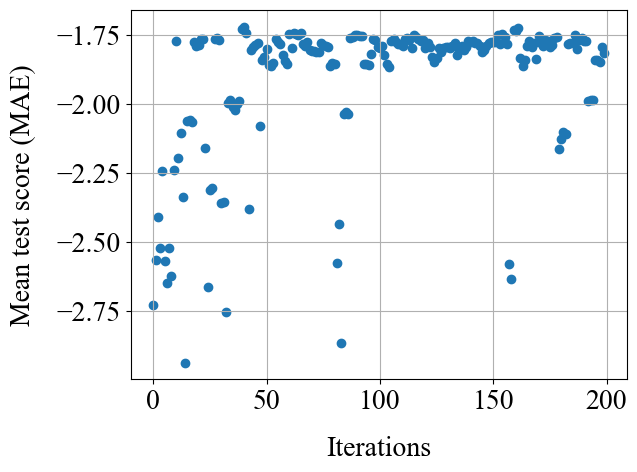

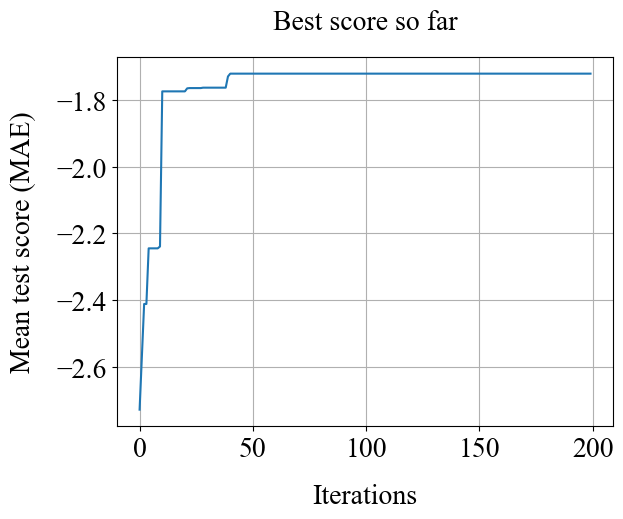


Hyperparameter values vs. scores


,param_clf__colsample_bytree,mean_test_score
40,1.0,-1.721413
161,1.0,-1.725218
39,1.0,-1.729900
159,1.0,-1.732315
160,1.0,-1.738467
62,1.0,-1.745754
41,1.0,-1.745839
65,1.0,-1.746070
60,1.0,-1.746685
154,1.0,-1.748863


,param_clf__gamma,mean_test_score
40,0.172610,-1.721413
161,0.196701,-1.725218
39,0.368560,-1.729900
159,0.202956,-1.732315
160,0.216797,-1.738467
62,0.433059,-1.745754
41,0.278477,-1.745839
65,0.100000,-1.746070
60,1.000000,-1.746685
154,0.212471,-1.748863


,param_clf__learning_rate,mean_test_score
40,0.040903,-1.721413
161,0.066196,-1.725218
39,0.012577,-1.729900
159,0.060659,-1.732315
160,0.056122,-1.738467
62,0.014324,-1.745754
41,0.175566,-1.745839
65,0.148484,-1.746070
60,0.018706,-1.746685
154,0.095839,-1.748863


,param_clf__max_depth,mean_test_score
40,5,-1.721413
161,6,-1.725218
39,5,-1.729900
159,6,-1.732315
160,6,-1.738467
62,5,-1.745754
41,6,-1.745839
65,8,-1.746070
60,8,-1.746685
154,7,-1.748863


,param_clf__min_child_weight,mean_test_score
40,1,-1.721413
161,1,-1.725218
39,1,-1.729900
159,1,-1.732315
160,1,-1.738467
62,1,-1.745754
41,1,-1.745839
65,1,-1.746070
60,1,-1.746685
154,1,-1.748863


,param_clf__n_estimators,mean_test_score
40,1614,-1.721413
161,2774,-1.725218
39,1835,-1.729900
159,2302,-1.732315
160,1760,-1.738467
62,2090,-1.745754
41,1204,-1.745839
65,1868,-1.746070
60,2574,-1.746685
154,1219,-1.748863


,param_clf__reg_alpha,mean_test_score
40,1.000000,-1.721413
161,0.879581,-1.725218
39,1.000000,-1.729900
159,0.162110,-1.732315
160,0.724519,-1.738467
62,1.000000,-1.745754
41,1.000000,-1.745839
65,0.687527,-1.746070
60,1.000000,-1.746685
154,0.736288,-1.748863


,param_clf__reg_lambda,mean_test_score
40,0.273548,-1.721413
161,0.619197,-1.725218
39,0.967305,-1.729900
159,0.618403,-1.732315
160,0.648352,-1.738467
62,0.992938,-1.745754
41,0.719606,-1.745839
65,0.448965,-1.746070
60,0.779030,-1.746685
154,0.527705,-1.748863


,param_clf__subsample,mean_test_score
40,0.849414,-1.721413
161,0.917304,-1.725218
39,0.853092,-1.729900
159,0.745104,-1.732315
160,1.000000,-1.738467
62,0.837780,-1.745754
41,0.872128,-1.745839
65,0.833270,-1.746070
60,0.902603,-1.746685
154,0.832261,-1.748863


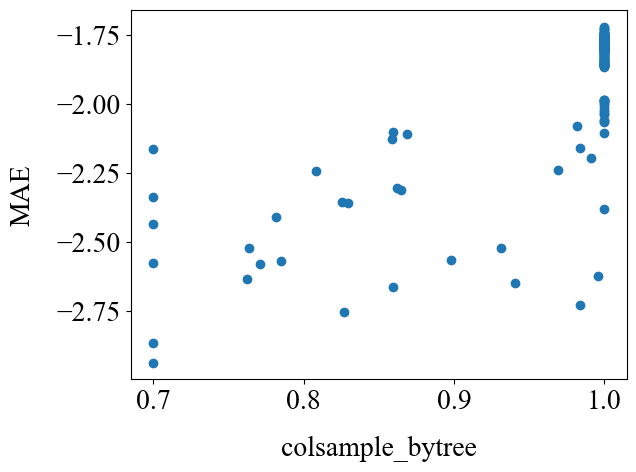

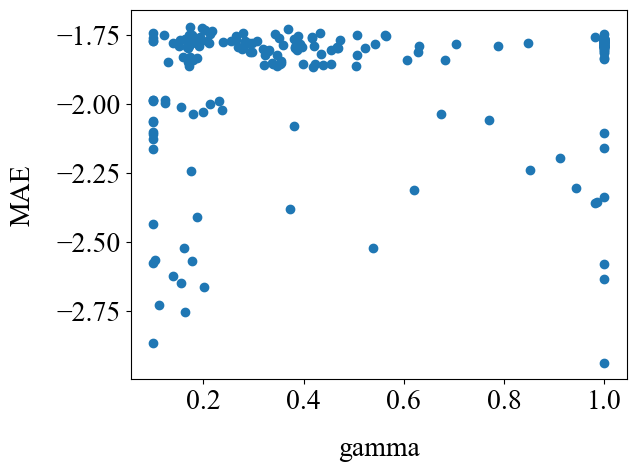

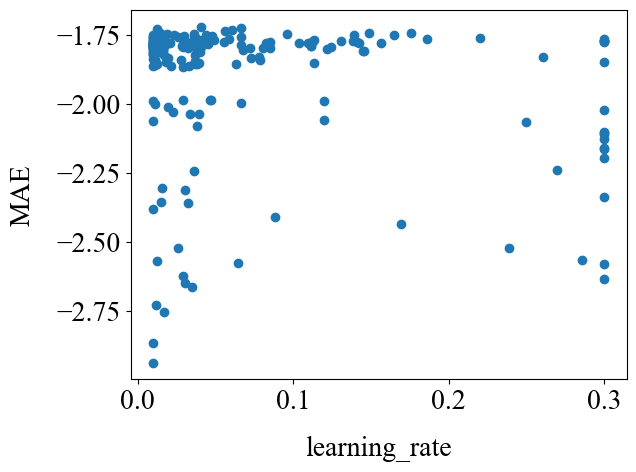

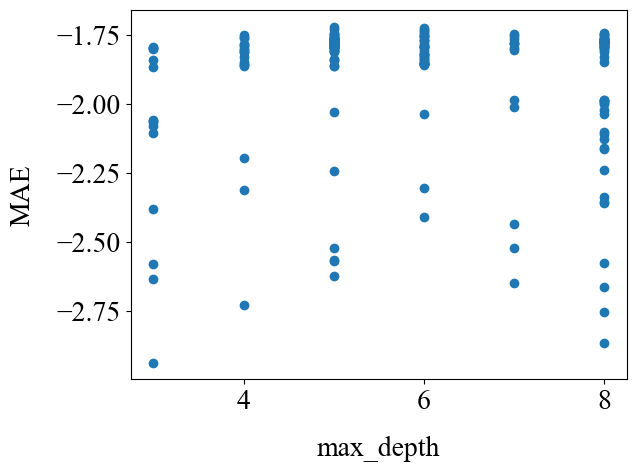

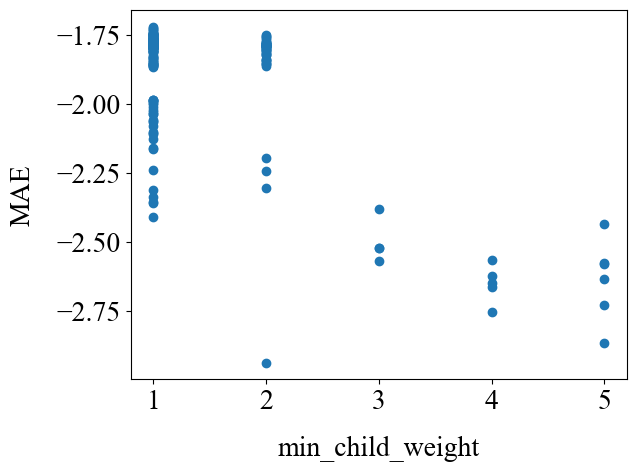

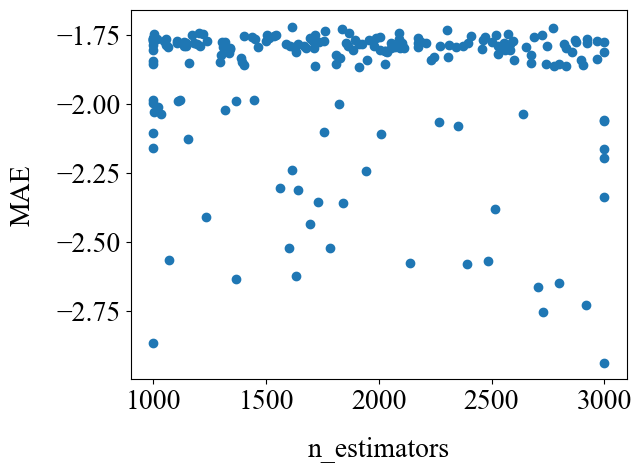

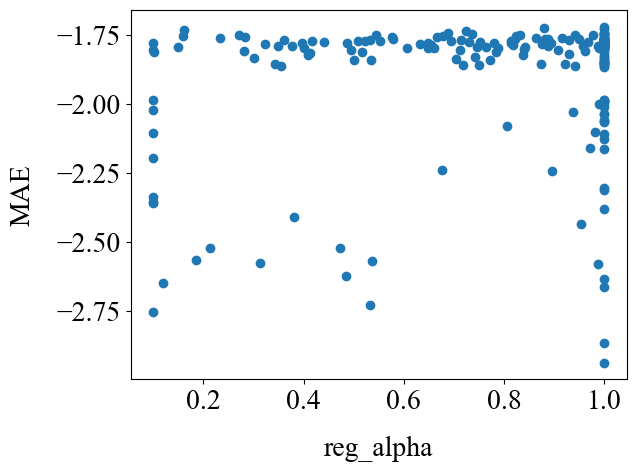

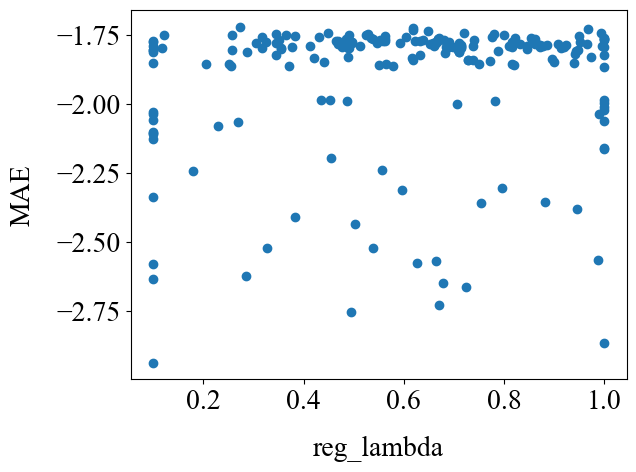

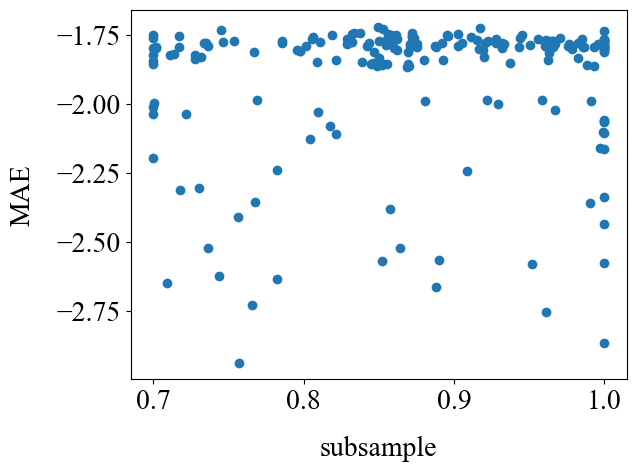


Hyperparameter histograms


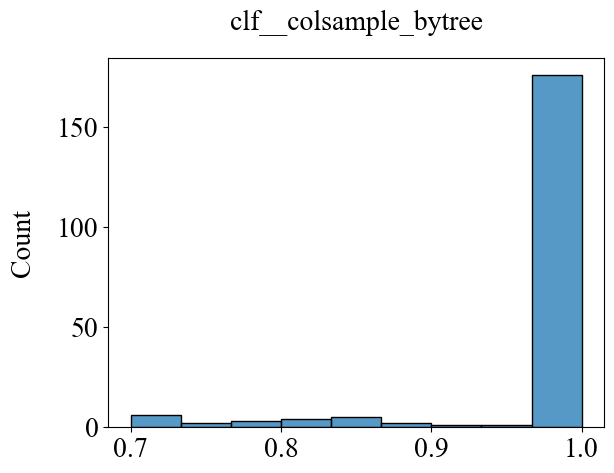

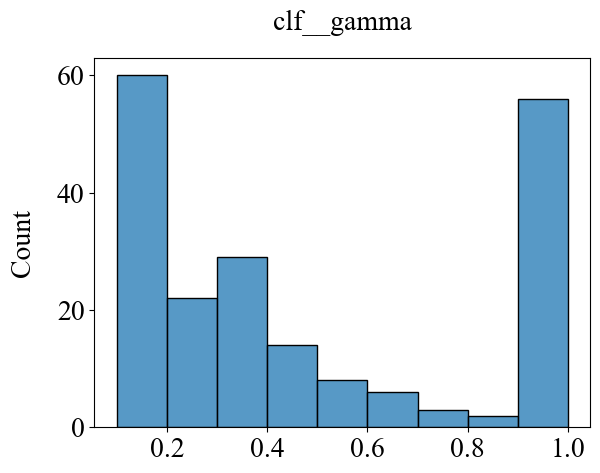

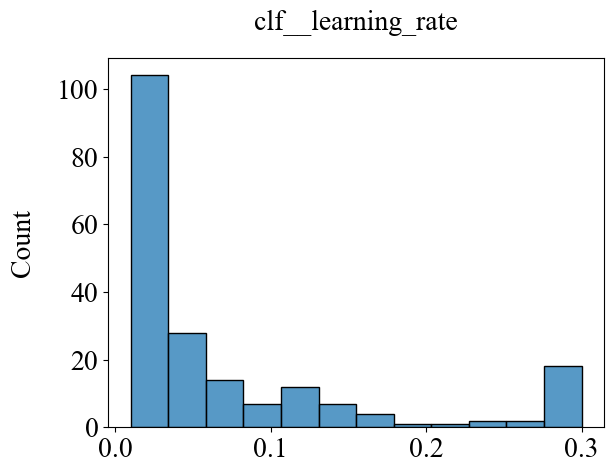

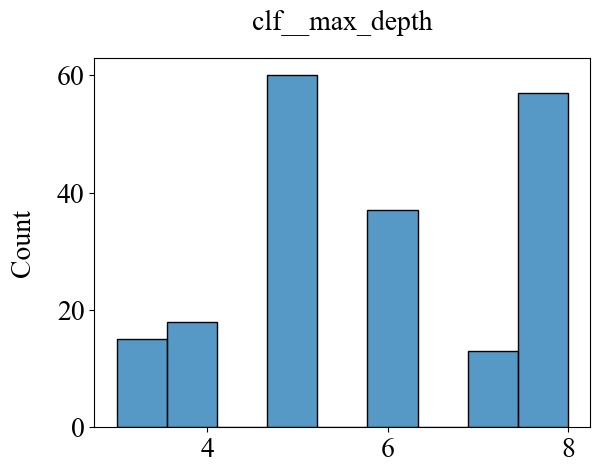

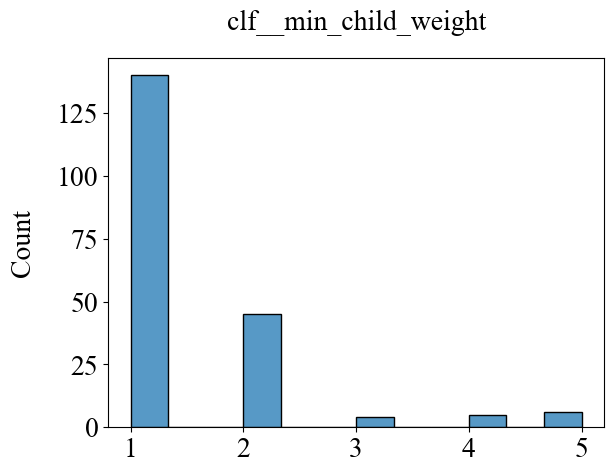

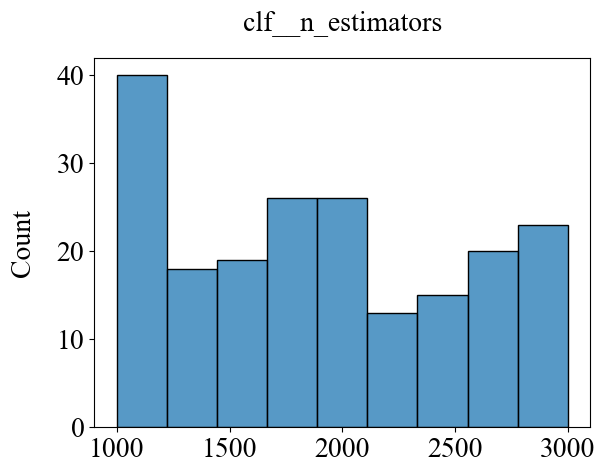

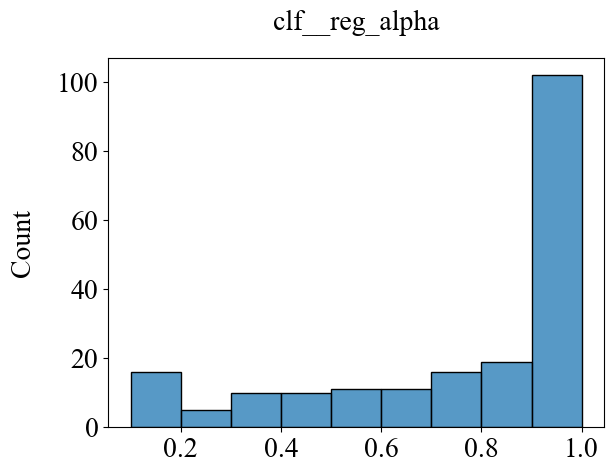

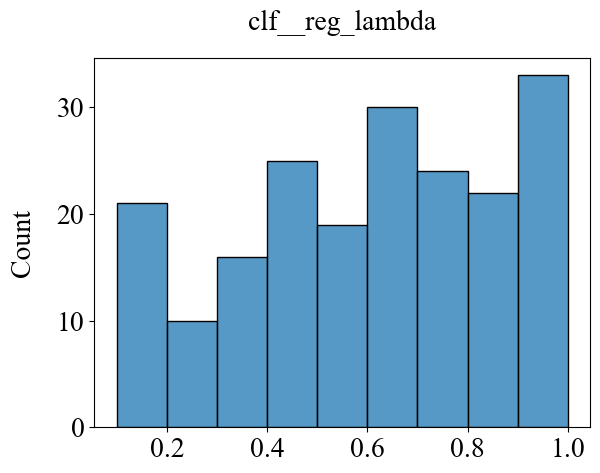

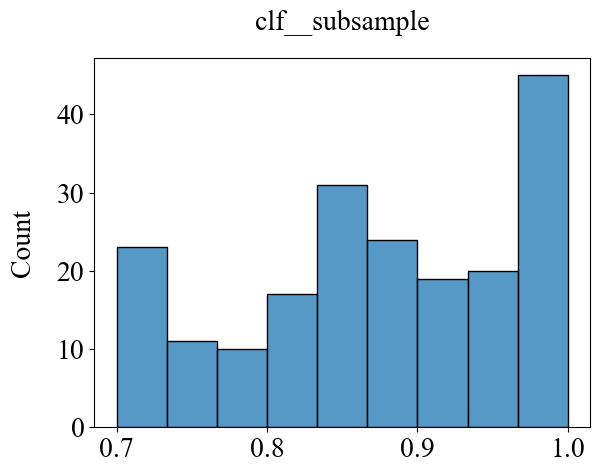

In [95]:
# Print best hyperparameters
best_params = predictor.trained_models[0]['opt'].best_params_
params_df = pd.DataFrame([best_params])
params_df = params_df.map(lambda x: ('%.3f' % x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
params_df = params_df.T
params_df.columns = ['' for _ in params_df.columns]
print('Best hyperparameter set')
display(params_df)

# Check convergence of the Bayesian optimization
bayescv_results = predictor.trained_models[0]['opt'].cv_results_
iterations = range(len(bayescv_results['mean_test_score']))
plt.scatter(iterations, bayescv_results['mean_test_score'])
plt.xlabel('Iterations')
plt.ylabel('Mean test score (MAE)')
# plt.ylabel('Mean test score (R²)')
plt.grid(True)
# plt.ylim(0, 1)
print('\nBayesian optimization convergence')
plt.show()

best_so_far = np.maximum.accumulate(bayescv_results['mean_test_score'])
plt.plot(best_so_far)
plt.title('Best score so far')
plt.xlabel('Iterations')
plt.ylabel('Mean test score (MAE)')
# plt.ylabel('Mean test score (R²)')
plt.grid(True)
plt.show()

# Look for hyperparameter clustering in top-performing CV
print('\nHyperparameter values vs. scores')
param_names = [key for key in bayescv_results.keys() if key.startswith('param_')]
results_df = pd.DataFrame(bayescv_results)
for param in param_names:
    display(results_df[[param, 'mean_test_score']].sort_values('mean_test_score', ascending=False).head(10))

for param in param_names:
    plt.scatter(bayescv_results[param], bayescv_results['mean_test_score'])
    plt.xlabel(str(param).replace('param_clf__', ''))
    plt.ylabel('MAE')
    # plt.ylabel('R² score')
    # plt.ylim(0, 1)
    plt.show()

# Plot hyperparameter histograms 
print('\nHyperparameter histograms')
for param in param_names:
    sns.histplot(bayescv_results[param])
    plt.title(param.replace('param_', '')) 
    plt.show()

In [90]:
# Compare performance to a simpler model
from sklearn.linear_model import Ridge
X_train = predictor.trained_models[0]['X_train']
y_train = predictor.trained_models[0]['y_train']
X_test = predictor.trained_models[0]['X_test']
y_test = predictor.trained_models[0]['y_test']

X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

ridge = Ridge().fit(X_train, y_train)
print("Ridge R²:", ridge.score(X_test, y_test))

Ridge R²: 0.964407723348588


In [97]:
i = 0
ratio = np.array(predictor.trained_models[i]['y_pred']) / np.array(predictor.trained_models[i]['y_test'])
ratio_mean = np.mean(ratio)
ratio_std = np.std(ratio)
ratio_ci = 1.96 * ratio_std / np.sqrt(len(ratio))
print(f'Overall predicted-actual ratio: {ratio_mean.round(2)} ± {ratio_ci.round(2)} (95% CI)')

ratio = ratio.round(2)
y_pred = np.array(predictor.trained_models[i]['y_pred'])
y_pred = np.round(y_pred, 2)
y_pred = np.array([f"{x:.2f}" for x in y_pred])

X_test_idx = predictor.trained_models[i]['X_test'].index
df = load_dataset(file_name='training-dataset.csv', target=predictor.target)
data = {
    'Author': df['Author'][X_test_idx],
    'Type of resin': df['Type of resin'][X_test_idx],
    'Type of fiber': df['Type of fiber'][X_test_idx],
    'Fiber volume fraction': df['Fiber volume fraction'][X_test_idx],
    'Profile thick. (mm)': df['Profile thickness (mm)'][X_test_idx],
    'Salt conc. (g/L)': df['Salt concentration (g/L)'][X_test_idx],
    'pH': df['pH'][X_test_idx],
    'Relative humidity': df['Relative humidity'][X_test_idx],
    'Exposure time (days)': df['Exposure time (days)'][X_test_idx],
    'Exposure temperature (°C)': df['Avg. exposure temperature (°C)'][X_test_idx],
    # 'Unaged elastic modulus (GPa)': df['Unaged elastic modulus (GPa)'][X_test_idx],
    'Actual residual modulus (GPa)': np.array(predictor.trained_models[i]['y_test']),
    'Predicted residual modulus (GPa)': y_pred,
    'Predicted-actual ratio': ratio
}
a = pd.DataFrame(data)
a.head(15)

Overall predicted-actual ratio: 1.01 ± 0.01 (95% CI)


,Author,Type of resin,Type of fiber,Fiber volume fraction,Profile thick. (mm),Salt conc. (g/L),pH,Relative humidity,Exposure time (days),Exposure temperature (°C),Actual residual modulus (GPa),Predicted residual modulus (GPa),Predicted-actual ratio
584,Kafodya et al. (2015),Epoxy,Carbon,NaN,1.4,35.0,8.5,1.00,28.0,23.0,165.7,165.68,1.00
146,Sousa et al. (2021),Vinylester,Glass,0.51,5.0,35.0,7.0,1.00,540.0,20.0,35.4,35.00,0.99
414,Miller (2014),Polyester,Glass,0.39,6.4,0.0,7.0,1.00,42.0,60.0,21.8,20.35,0.93
425,Miller (2014),Polyester,Glass,0.39,6.4,35.0,7.0,1.00,42.0,60.0,20.1,20.30,1.01
281,Fam et al. (2016),Polyester,Glass,0.32,4.2,30.0,7.0,1.00,14.0,23.0,28.7,29.28,1.02
158,Sousa et al. (2021),Vinylester,Glass,0.51,5.0,35.0,7.0,1.00,270.0,60.0,32.7,34.52,1.06
325,Carra and Carvelli (2014),Polyester,Glass,0.60,2.9,0.0,7.0,0.90,28.0,40.0,31.3,31.74,1.01
410,Yang et al. (2022),Polyester,Glass,0.60,2.7,0.0,7.0,0.94,360.0,40.0,5.0,6.16,1.23
106,Sousa et al. (2021),Polyester,Glass,0.51,5.0,35.0,7.0,1.00,0.0,40.0,37.4,35.70,0.95
144,Sousa et al. (2021),Vinylester,Glass,0.51,5.0,35.0,7.0,1.00,270.0,20.0,33.1,35.61,1.08


In [ ]:
# Test models on holdout data (not used during training)
holdout_test_df = predictor.holdout_test(file_name='holdout-dataset.csv',
    cols_to_drop=cols_to_drop, cols_to_hold=['Author', 'Type of resin', 'Type of fiber'])
display(holdout_test_df)

In [98]:
i=0
display(f'Model {i+1} best hyperparameters', predictor.trained_models[i]['model']['clf'].get_params())

'Model 1 best hyperparameters'

{'objective': 'reg:squarederror',
 'base_score': 1.0,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'mae',
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': [['Avg. exposure temperature (°C)',
   'Exposure time (days)'],
  ['1/T (Kelvin)', 'log10(t)']],
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': (1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 1, 0),
 'multi_strategy': None,
 'n_estimators': 3000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 1.0,
 'reg_lambda': 0.3957388210895959,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1.0,

Predictions [[[24.    23.978 23.766 23.103 22.478 22.478 22.199 22.199 21.81  21.81 ]
  [24.    23.522 23.522 22.935 22.285 22.285 21.782 21.782 21.393 21.393]
  [24.    23.264 23.264 22.935 22.129 22.129 20.489 20.489 20.489 20.489]]

 [[24.    23.464 23.308 22.788 22.407 22.361 22.142 22.142 22.08  22.08 ]
  [24.    23.017 23.012 22.386 21.942 21.896 21.647 21.647 21.585 21.585]
  [24.    22.818 22.812 22.118 21.371 21.324 20.064 20.064 20.064 20.064]]

 [[24.    24.383 24.383 24.035 23.182 23.182 23.01  23.01  22.974 22.974]
  [24.    24.13  24.13  23.783 22.93  22.93  22.758 22.758 22.722 22.722]
  [24.    23.903 23.903 23.712 22.768 22.768 21.633 21.633 21.589 21.589]]

 [[24.    24.994 24.848 24.371 23.891 23.872 23.477 23.477 23.333 23.333]
  [24.    24.636 24.619 24.205 23.672 23.631 23.232 23.232 23.083 23.083]
  [24.    24.199 24.081 23.946 23.592 23.578 22.145 22.145 22.062 22.062]]] 

t [days]:  [  1.  20.  50. 100. 150. 250. 365. 500. 730. 913.]
E(t, 20 °C):  [24.   24.2  

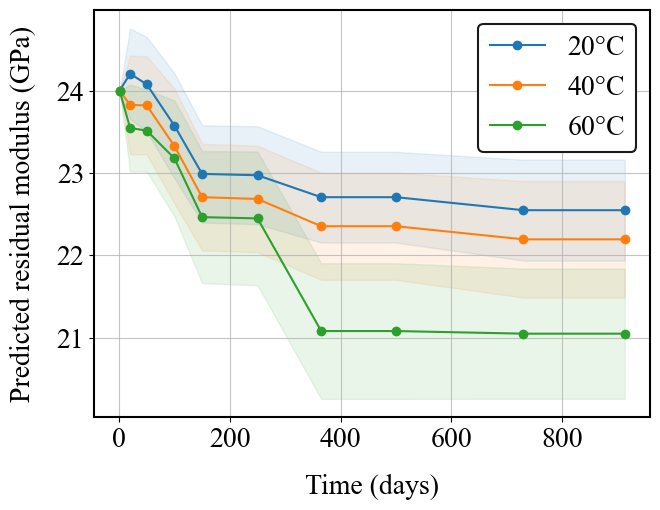

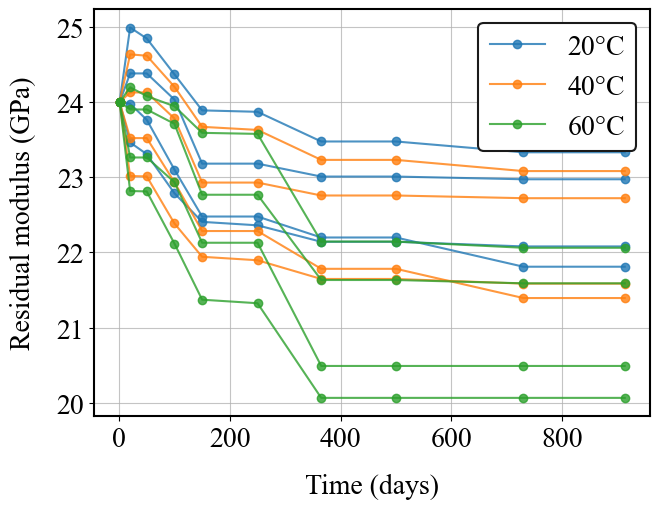

[['-0.00e+00' '-7.64e-08' '-1.19e-08' '4.02e-08' '9.20e-08' '5.69e-08'
  '7.04e-08' '5.14e-08' 'nan' 'nan']
 ['-0.00e+00' '5.86e-08' '2.42e-08' '5.40e-08' '9.73e-08' '6.04e-08'
  '7.70e-08' '5.62e-08' 'nan' 'nan']
 ['-0.00e+00' '9.67e-08' '4.16e-08' '3.78e-08' '5.67e-08' '3.45e-08'
  '1.44e-07' '1.05e-07' 'nan' 'nan']]


In [100]:
# Test: evaluate prediction time series using cooling tower data

from scipy.optimize import curve_fit

file_name_pred = 'prediction-dataset.csv'
file_name_arrh = 'arrhenius-fitting-dataset.csv'
log_transf = []
unaged_modulus = 24.0

# Definition of dataset path
file_path_pred = str(os.getcwd()) + '\\' + file_name_pred
file_path_arrh = str(os.getcwd()) + '\\' + file_name_arrh

# Read .CSV as pandas dataframe
df_pred = pd.read_csv(file_path_pred, delimiter=';')
df_arrh = pd.read_csv(file_path_arrh, delimiter=';')

# Drop columns that are not important for the analysis
df_pred = df_pred.drop(columns=cols_to_drop)
df_arrh = df_arrh.drop(columns=cols_to_drop)

# Remove unnamed columns
df_pred = df_pred.loc[:, ~df_pred.columns.str.contains('^Unnamed')]
df_arrh = df_arrh.loc[:, ~df_arrh.columns.str.contains('^Unnamed')]

# Filter target property values that appear less than min_target_count times
value_counts = df_pred[predictor.target].value_counts()
valid_values = value_counts[value_counts > 0].index
df_pred = df_pred[df_pred[predictor.target].isin(valid_values)]

value_counts = df_arrh[predictor.target].value_counts()
valid_values = value_counts[value_counts > 0].index
df_arrh = df_arrh[df_arrh[predictor.target].isin(valid_values)]

# Log-transform features with outlier values
for i in range(len(log_transf)):
    df_pred[log_transf[i]] = np.log10(df_pred[log_transf[i]])

for i in range(len(log_transf)):
    df_arrh[log_transf[i]] = np.log10(df_arrh[log_transf[i]])

# Separate independent variables from target
X_pred = df_pred.drop(columns=predictor.target)
X_arrh = df_arrh.drop(columns=predictor.target)

y_preds = []
for i in range(len(predictor.trained_models)):
    y_pred = predictor.trained_models[i]['model'].predict(X_pred).tolist()
    for j in range(len(y_pred)):
        y_pred[j] = round(y_pred[j], 2)
    y_pred[0] = 24 # Enforce retention equal to 1 at t=0 for physical reasoning (fluctuates between 0.98, 0.99, 1.00)
    y_preds.append(y_pred)
    # print(y_pred)

# print(np.array(y_preds).shape)
# print(np.array(y_preds))

y_arrhs = []
for i in range(len(predictor.trained_models)):
    y_arrh = predictor.trained_models[i]['model'].predict(X_arrh).tolist()
    for j in range(len(y_arrh)):
        y_arrh[j] = round(y_arrh[j], 3)
    y_arrh[0] = 24  # Enforce retention equal to 1 at t=0 for physical reasoning (fluctuates between 0.98, 0.99, 1.00)    
    y_arrh[10] = 24
    y_arrh[20] = 24
    # y_arrh[5] = 1
    # y_arrh[10] = 1
    # print(y_arrh)
    y_arrhs.append(y_arrh)

# y_preds = np.mean(y_preds, axis=0)
y_arrhs_ = np.array(y_arrhs)
y_arrh = np.mean(y_arrhs, axis=0)
y_arrh_std = np.std(y_arrhs, axis=0)  # Standard deviation
y_arrh_ci = 1.96 * y_arrh_std / np.sqrt(len(predictor.trained_models))  # 95% confidence interval

# Prediction time series
t_pred = [0, 91.25, 182.5, 273.75, 365, 456.25, 547.5, 730, 912.5, 1095]    # Exposure time for prediction plot (days)
t_arrh = np.array([1, 20, 50, 100, 150, 250, 365, 500, 730, 913])           # Exposure time for Arrhenius extrapolation (days)
t_arrh = t_arrh * 24 * 3600                                                 # Convert to seconds
T = np.array([20, 40, 60]) + 273.15                                         # Temperatures for fitting Arrhenius equation (Kelvin)

y_arrhs_ = y_arrhs_.reshape(len(predictor.trained_models), len(T), len(t_arrh))
print('Predictions', y_arrhs_, '\n')

y_arrh = y_arrh.reshape(len(T), len(t_arrh))  # rows: T, cols: t
y_arrh_std = y_arrh_std.reshape(len(T), len(t_arrh))  # rows: T, cols: t
y_arrh_ci = y_arrh_ci.reshape(len(T), len(t_arrh))  # rows: T, cols: t

# Plot residual modulus time series (all models aggregated)
print('t [days]: ', t_arrh / (24 * 3600))
print('E(t, 20 °C): ', y_arrh[0].round(2))
print('E(t, 40 °C): ', y_arrh[1].round(2))
print('E(t, 60 °C): ', y_arrh[2].round(2))

plt.figure(figsize=(7, 5.5))
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, (temp, color) in enumerate(zip(T, colors)):
    plt.plot(t_arrh / (24*3600), y_arrh[i], 'o-', color=color, label=f'{temp-273.15:.0f}°C')
    plt.fill_between(
        t_arrh / (24*3600),
        y_arrh[i] - y_arrh_ci[i],
        y_arrh[i] + y_arrh_ci[i],
        color=color,
        alpha=0.1
    )
plt.xlabel('Time (days)')
plt.ylabel('Predicted residual modulus (GPa)')
plt.legend()
plt.grid(True, alpha=0.75)
legend = plt.legend(loc='upper right', frameon=True, fancybox=True,
framealpha=1, edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
plt.tight_layout()
plt.show()

# Plot residual modulus time series (individual models)
plt.figure(figsize=(7, 5.5))
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, (temp, color) in enumerate(zip(T, colors)):
    for j in range(len(predictor.trained_models)):
        if j == 0:
            plt.plot(t_arrh / (24*3600), y_arrhs_[j][i], 'o-', color=color,
                alpha=0.8, label=f'{temp-273.15:.0f}°C')
        else:
            plt.plot(t_arrh / (24*3600), y_arrhs_[j][i], 'o-', color=color, alpha=0.8)
plt.xlabel('Time (days)')
plt.ylabel('Residual modulus (GPa)')
plt.legend()
plt.grid(True, alpha=0.75)
legend = plt.legend(loc='upper right', frameon=True, fancybox=True,
framealpha=1, edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
plt.tight_layout()
plt.show()

# # Plot modulus retention time series
# r_1 = y_arrh[0] / unaged_modulus
# r_2 = y_arrh[1] / unaged_modulus
# r_3 = y_arrh[2] / unaged_modulus
# print('t [days]: ', t_arrh / (24 * 3600))
# print('r(t, 20 °C): ', r_1.round(2))
# print('r(t, 40 °C): ', r_2.round(2))
# print('r(t, 60 °C): ', r_3.round(2))

# plt.figure(figsize=(7, 5.5))
# plt.gca().spines['top'].set_linewidth(1.5)
# plt.gca().spines['right'].set_linewidth(1.5)
# plt.gca().spines['left'].set_linewidth(1.5)
# plt.gca().spines['bottom'].set_linewidth(1.5)
# colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c'])
# for i, (temp, color) in enumerate(zip(T, colors)):
#     plt.plot(t_arrh / (24*3600), y_arrh[i] / unaged_modulus, 'o-', color=color, label=f'{temp-273.15:.0f}°C')
#     plt.fill_between(
#         t_arrh / (24*3600),
#         y_arrh[i] / unaged_modulus - y_arrh_ci[i] / unaged_modulus,
#         y_arrh[i] / unaged_modulus + y_arrh_ci[i] / unaged_modulus,
#         color=color,
#         alpha=0.1
#     )
# plt.xlabel('Time (days)')
# plt.ylabel('Predicted modulus retention')
# plt.legend()
# plt.grid(True, alpha=0.75)
# legend = plt.legend(loc='upper right', frameon=True, fancybox=True,
# framealpha=1, edgecolor='black', facecolor='white')
# legend.get_frame().set_linewidth(1.5)
# legend.get_frame().set_edgecolor((0.1, 0.1, 0.1))
# plt.tight_layout()
# plt.show()

# Calculate degradation rate k(T)
k_T = np.zeros((len(T), len(t_arrh)))
for i in range(len(T)):
    for j in range(len(t_arrh)):
        if y_arrh[i][j] != y_arrh[i][-1]:
            k = -np.log((y_arrh[i][j] - y_arrh[i][-1]) /
            (unaged_modulus - y_arrh[i][-1])) / t_arrh[j]
        else:
            k = None
        k_T[i][j] = k

# print('k_T: ', k_T)
formatter = np.vectorize(lambda x: f"{x:.2e}")
formatted = formatter(k_T)
print(formatted)

# Plot ln((E - E∞)/(E_0 - E∞)) vs 1/t


# plt.plot(t_arrh/ (24*3600), y_arrhs[0], color='blue')
# plt.plot(t_arrh/ (24*3600), y_arrhs[1], color='red')
# plt.plot(t_arrh/ (24*3600), y_arrhs[2], color='green')
# plt.show()

Final train MAE: 1.403 ± 0.008
Final valid MAE: 1.633 ± 0.006


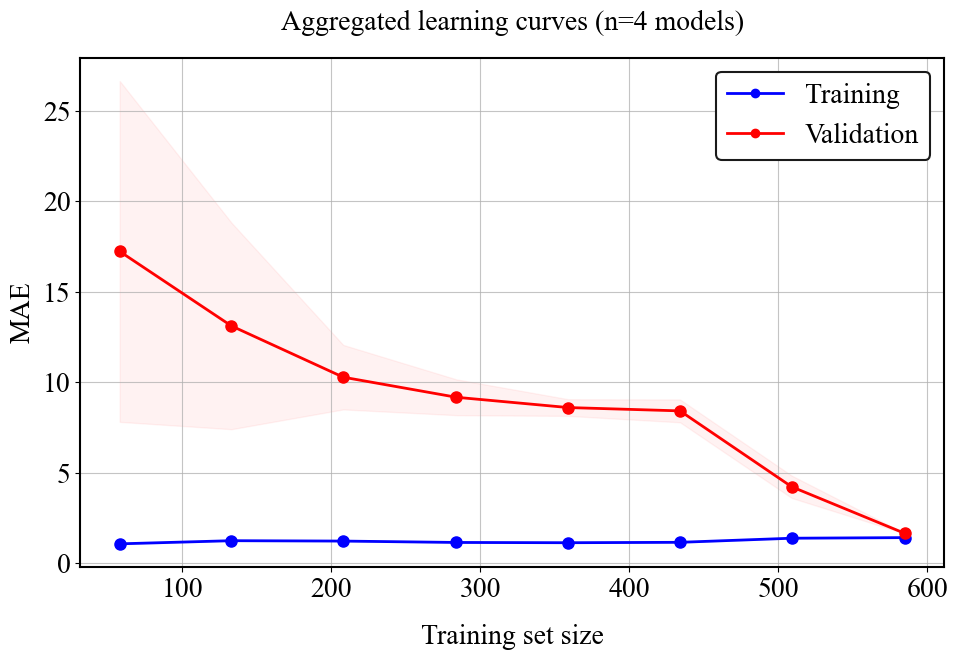

Final train RMSE: 2.049 ± 0.006
Final valid RMSE: 2.384 ± 0.068


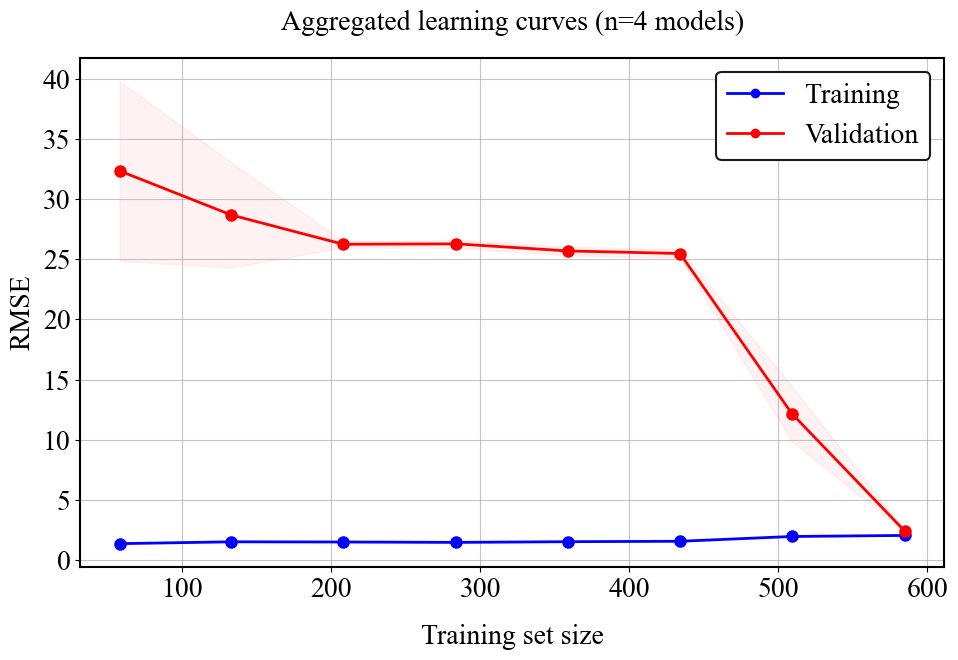

Final train R²: 0.995 ± 0.000
Final valid R²: 0.991 ± 0.002


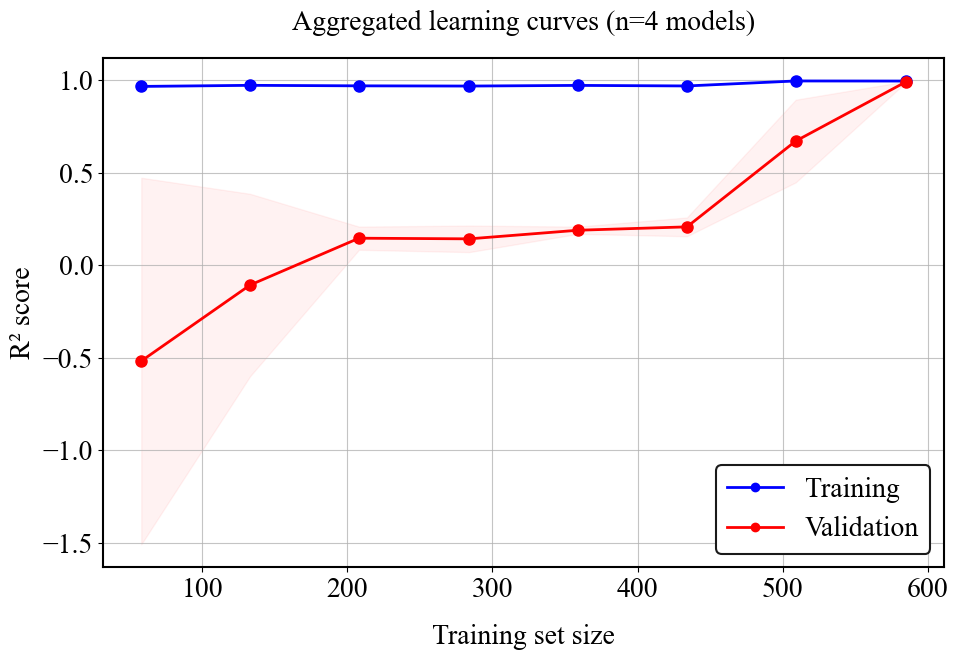

In [101]:
for i in range(len(predictor.trained_models)):
    predictor.trained_models[i]['model']['clf'].set_params(early_stopping_rounds=None)

predictor.plot_learning_curves(metrics=[1,1,1], ylim_1=None, ylim_2=None, ylim_3=None)


Target boxplot distribution


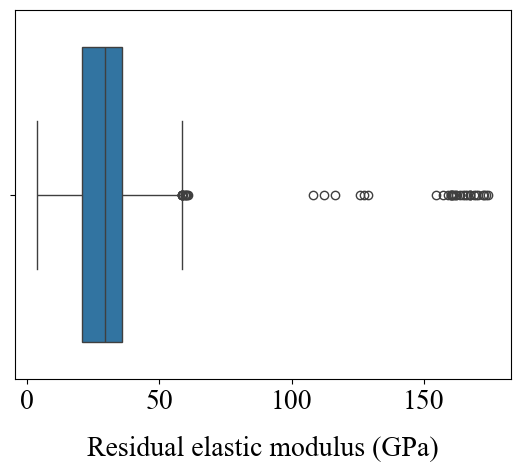


Overall feature distribution


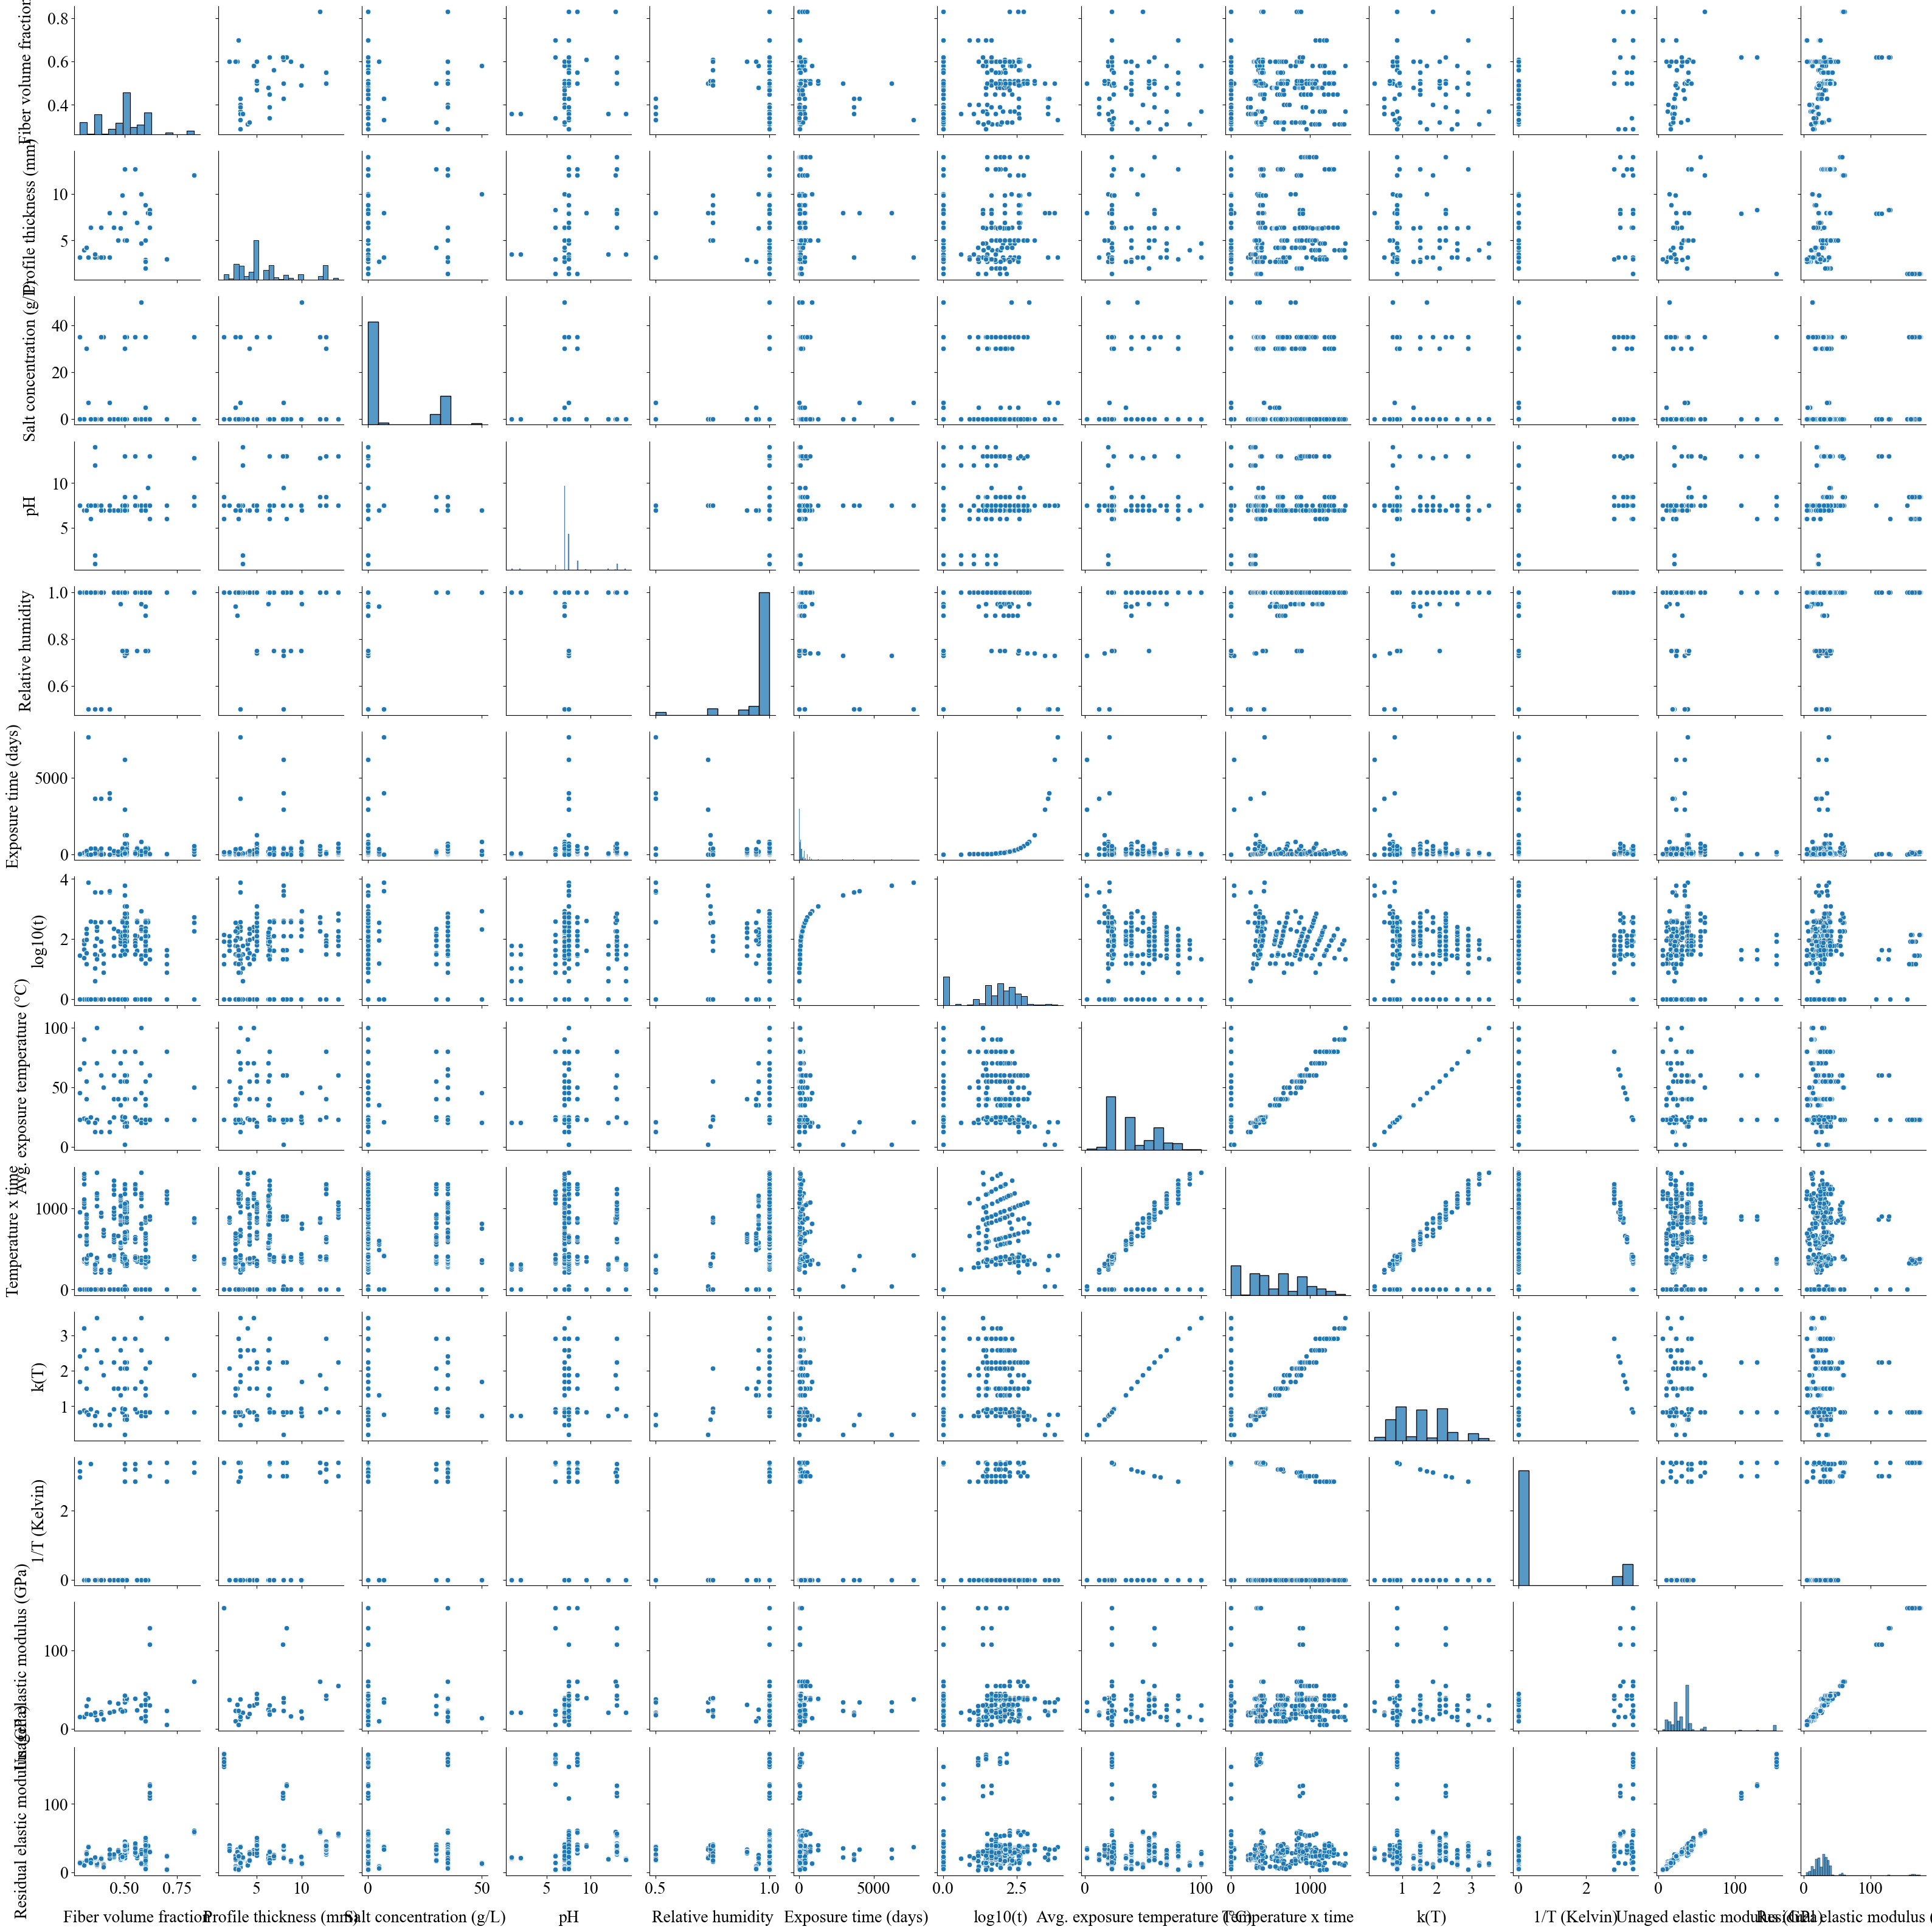


Most important feature vs. target


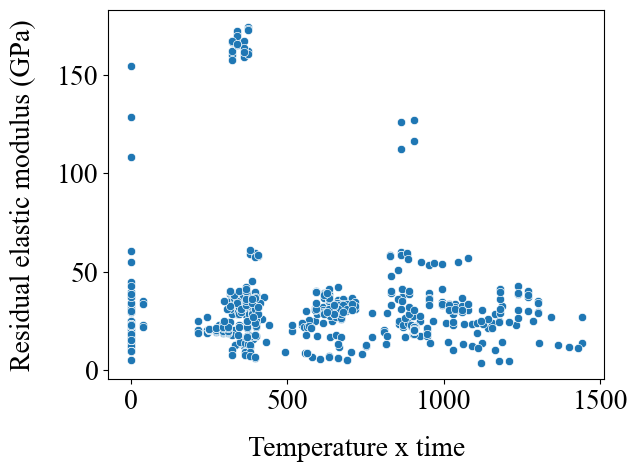

In [102]:
predictor.plot_feature_distribution(main_feature='Temperature x time')

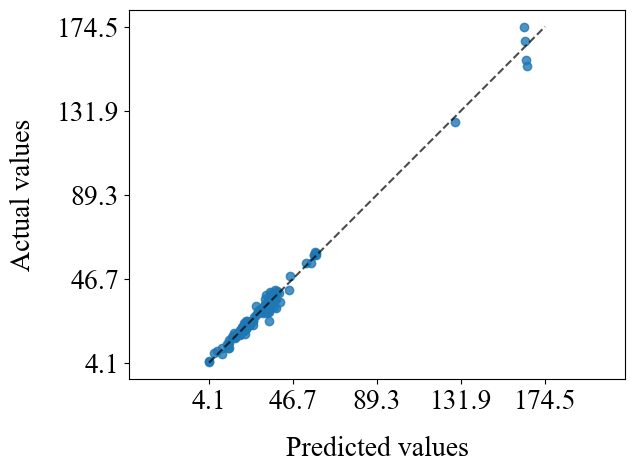

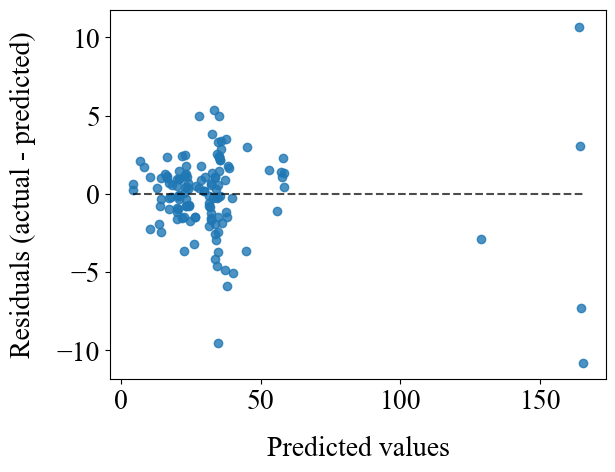

In [103]:
predictor.plot_pred_error(i=1)


Model 1


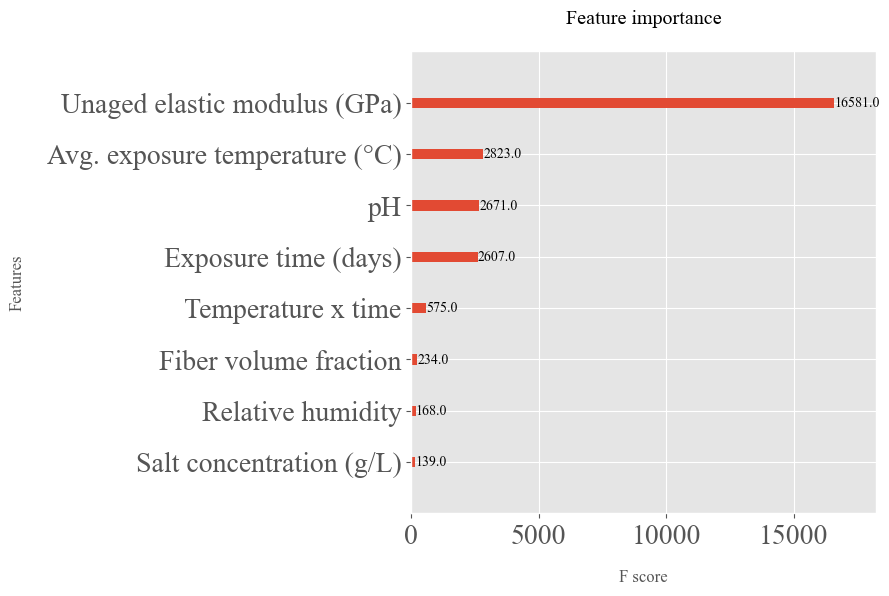

In [119]:
# Plot feature importance
predictor.plot_importance(i=0, itype='weight')
# Importance type ('weight', 'gain', 'cover', 'total_gain', 'total_cover')

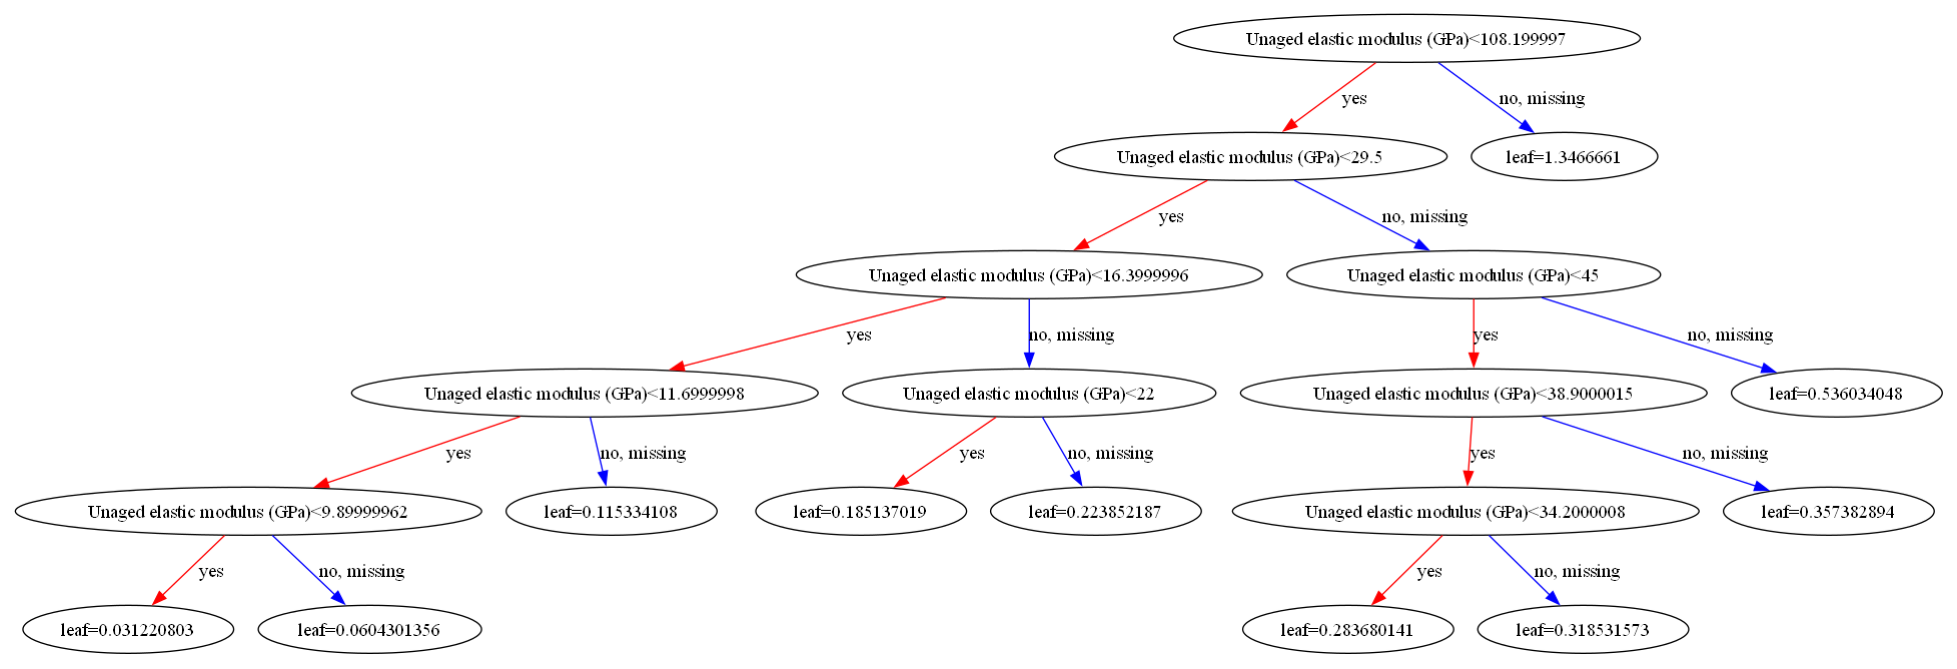

In [106]:
predictor.plot_tree()

In [ ]:
df = load_dataset(file_name='training-dataset.csv', target=predictor.target, cols_to_drop=cols_to_drop)
X = df.drop(columns=predictor.target)
y = df[predictor.target]

# Outer CV: Evaluate performance
overall_outer_scores = []
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=predictor.cv_strategy, 
        scoring='neg_mean_absolute_error'
    )
    for j in range(len(outer_scores)):
        overall_outer_scores.append(outer_scores[j])
    print(f"Unbiased model {i+1} MAE: {-np.mean(outer_scores):.3f} ± {abs(np.std(outer_scores)):.3f}")
conf_int = 1.96 * abs(np.std(overall_outer_scores)) / np.sqrt(len(overall_outer_scores))
print(f"Total unbiased MAE: {-np.mean(overall_outer_scores):.3f} ± {abs(np.std(overall_outer_scores)):.3f} (SD)")
print(f"Total unbiased MAE: {-np.mean(overall_outer_scores):.3f} ± {conf_int:.3f} (95% CI)\n")

overall_outer_scores = []
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=predictor.cv_strategy, 
        scoring='neg_mean_absolute_percentage_error'
    )
    for j in range(len(outer_scores)):
        overall_outer_scores.append(outer_scores[j])
    print(f"Unbiased model {i+1} MAPE: {-np.mean(outer_scores):.3f} ± {abs(np.std(outer_scores)):.3f}")
conf_int = 1.96 * abs(np.std(overall_outer_scores)) / np.sqrt(len(overall_outer_scores))
print(f"Total unbiased MAPE: {-np.mean(overall_outer_scores):.3f} ± {abs(np.std(overall_outer_scores)):.3f} (SD)")
print(f"Total unbiased MAPE: {-np.mean(overall_outer_scores):.3f} ± {conf_int:.3f} (95% CI)\n")

overall_outer_scores = []
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=predictor.cv_strategy, 
        scoring='neg_root_mean_squared_error'
    )
    for j in range(len(outer_scores)):
        overall_outer_scores.append(outer_scores[j])
    print(f"Unbiased model {i+1} RMSE: {-np.mean(outer_scores):.3f} ± {abs(np.std(outer_scores)):.3f}")
conf_int = 1.96 * abs(np.std(overall_outer_scores)) / np.sqrt(len(overall_outer_scores))
print(f"Total unbiased RMSE: {-np.mean(overall_outer_scores):.3f} ± {abs(np.std(overall_outer_scores)):.3f} (SD)")
print(f"Total unbiased RMSE: {-np.mean(overall_outer_scores):.3f} ± {conf_int:.3f} (95% CI)\n")

overall_outer_scores = []
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=predictor.cv_strategy, 
        scoring='r2'
    )
    for j in range(len(outer_scores)):
        overall_outer_scores.append(outer_scores[j])
    print(f"Unbiased R²: {np.mean(outer_scores):.2f} ± {np.std(outer_scores):.2f}")
conf_int = 1.96 * abs(np.std(overall_outer_scores)) / np.sqrt(len(overall_outer_scores))
print(f"Total unbiased R²: {np.mean(overall_outer_scores):.2f} ± {np.std(overall_outer_scores):.2f} (SD)")
print(f"Total unbiased R²: {np.mean(overall_outer_scores):.2f} ± {conf_int:.2f} (95% CI)")

In [109]:
predictor.lin_correl()

Unaged elastic modulus (GPa)      0.993065
1/T (Kelvin)                      0.554292
Fiber volume fraction             0.409420
pH                                0.134415
Salt concentration (g/L)          0.081827
Relative humidity                 0.072626
log10(t)                          0.030256
Exposure time (days)             -0.025740
Temperature x time               -0.066154
Profile thickness (mm)           -0.082367
Avg. exposure temperature (°C)   -0.156662
k(T)                             -0.158871
dtype: float64


95% prediction interval: ±4.90


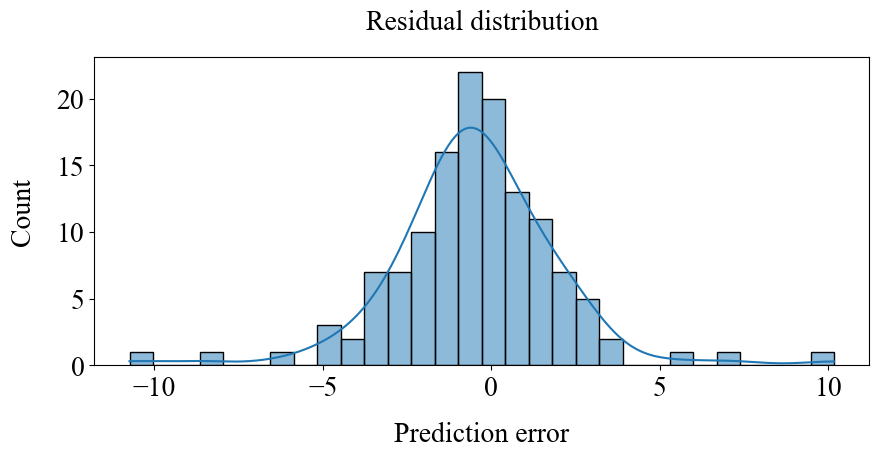

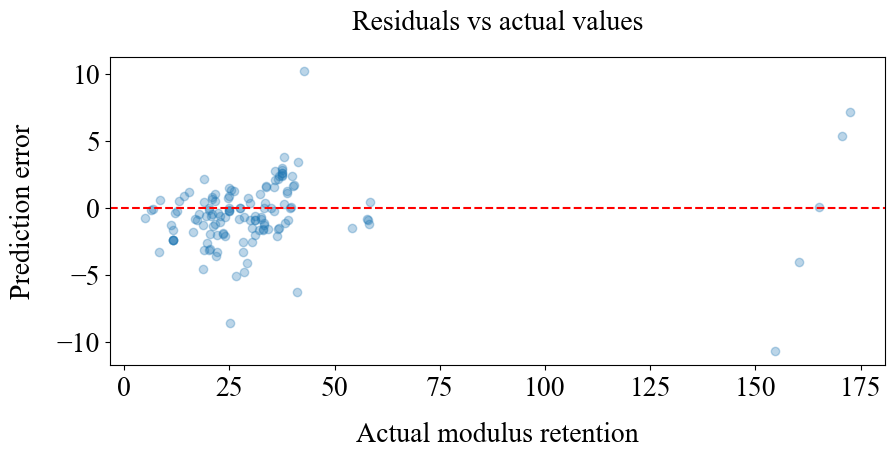

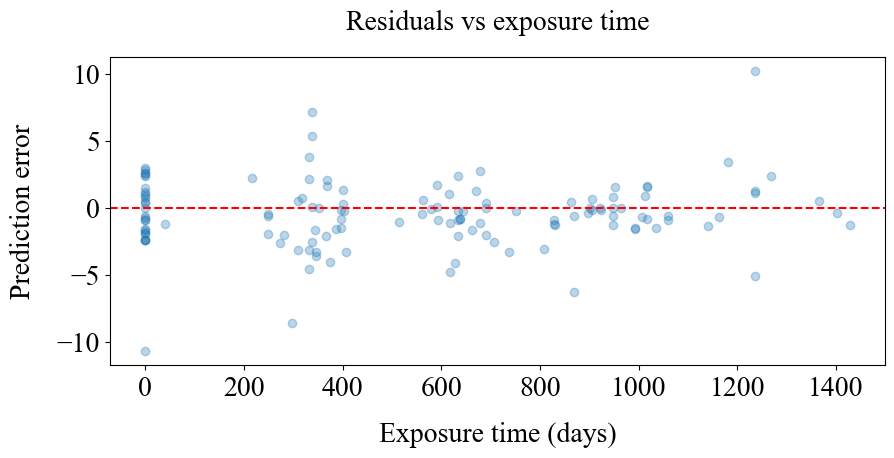

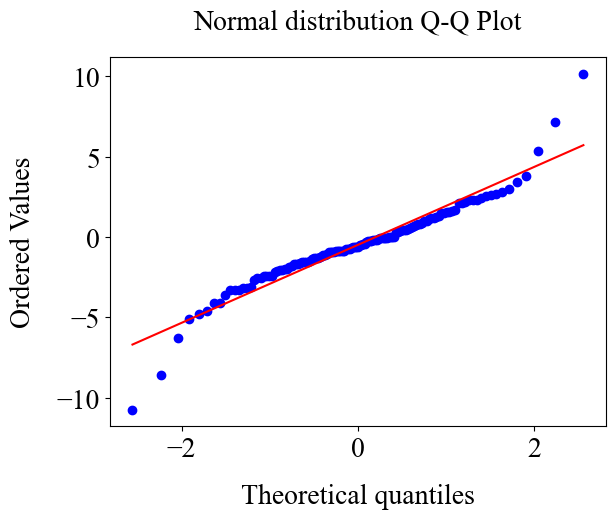

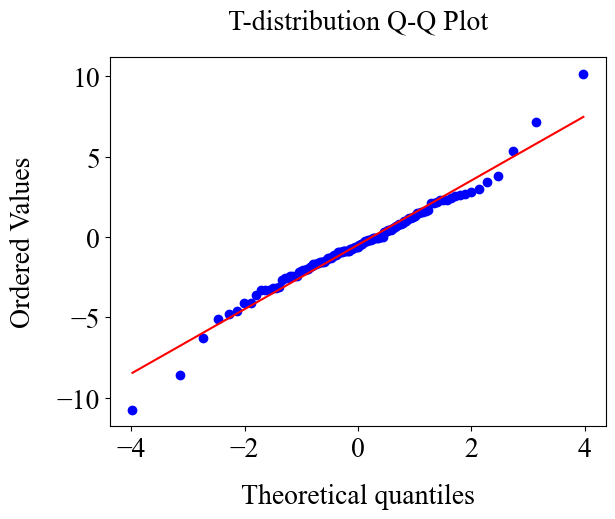

In [110]:
predictor.residual_analysis(model_i=3, feature='Temperature x time')

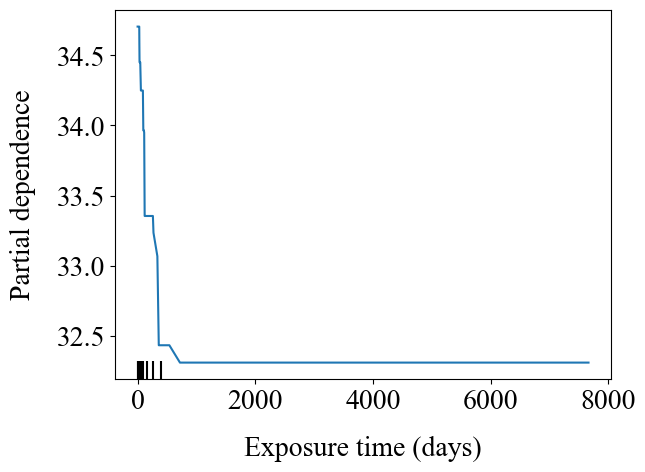

In [111]:
predictor.pdp(model_i=0, feature='Exposure time (days)')

In [112]:
# Fim do processamento
now = datetime.now()

print(now.strftime("%d/%m/%Y %H:%M:%S"))
print("\nProcessing time: %s seconds\n" % (round((time.time() - start_time), 2)))

27/04/2025 22:39:20

Processing time: 5365.37 seconds

